# **FPL MODEL PREDICTION TEAM 39**

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set the style for seaborn plots for better aesthetics
sns.set_style('whitegrid')

# 2. Loading The Dataset

In [3]:
# from google.colab import files
# files.upload()

In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download joebeachcapital/fantasy-football
# !unzip fantasy-football.zip

In [5]:
df = pd.read_csv('cleaned_merged_seasons.csv')

/tmp/ipython-input-1169936001.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_merged_seasons.csv')


# 3. Inspecting Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           96169 non-null  object 
 1   name               96169 non-null  object 
 2   position           96169 non-null  object 
 3   team_x             76317 non-null  object 
 4   assists            96169 non-null  int64  
 5   bonus              96169 non-null  int64  
 6   bps                96169 non-null  int64  
 7   clean_sheets       96169 non-null  int64  
 8   creativity         96169 non-null  float64
 9   element            96169 non-null  int64  
 10  fixture            96169 non-null  int64  
 11  goals_conceded     96169 non-null  int64  
 12  goals_scored       96169 non-null  int64  
 13  ict_index          96169 non-null  float64
 14  influence          96169 non-null  float64
 15  kickoff_time       96169 non-null  object 
 16  minutes            961

In [7]:
df.isnull().sum()

season_x                 0
name                     0
position                 0
team_x               19852
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
element                  0
fixture                  0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
kickoff_time             0
minutes                  0
opponent_team            0
opp_team_name            0
own_goals                0
penalties_missed         0
penalties_saved          0
red_cards                0
round                    0
saves                    0
selected                 0
team_a_score             0
team_h_score             0
threat                   0
total_points             0
transfers_balance        0
transfers_in             0
transfers_out            0
value                    0
was_home                 0
yellow_cards             0
GW                       0
dtype: int64

In [8]:
df['position'].value_counts()

position
MID    39163
DEF    33683
FWD    12669
GK     10553
GKP      101
Name: count, dtype: int64

In [9]:
df.head()

season_x                name position team_x  assists  bonus  bps  \
0  2016-17     Aaron Cresswell      DEF    NaN        0      0    0   
1  2016-17        Aaron Lennon      MID    NaN        0      0    6   
2  2016-17        Aaron Ramsey      MID    NaN        0      0    5   
3  2016-17  Abdoulaye Doucouré      MID    NaN        0      0    0   
4  2016-17        Adam Forshaw      MID    NaN        0      0    3   

   clean_sheets  creativity  element  ...  team_h_score  threat  total_points  \
0             0         0.0      454  ...           2.0     0.0             0   
1             0         0.3      142  ...           1.0     0.0             1   
2             0         4.9       16  ...           3.0    23.0             2   
3             0         0.0      482  ...           1.0     0.0             0   
4             0         1.3      286  ...           1.0     0.0             1   

   transfers_balance  transfers_in transfers_out  value  was_home  \
0                  0             0             0     55     False   
1                  0             0             0     60      True   
2                  0             0             0     80      True   
3                  0             0             0     50     False   
4                  0             0             0     45      True   

  yellow_cards  GW  
0            0   1  
1            0   1  
2            0   1  
3            0   1  
4            1   1  

[5 rows x 37 columns]

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
print(df['season_x'].unique())

['2016-17' '2017-18' '2020-21' '2021-22' '2022-23']


# 4. Data Cleaning + Data Analysis

### Removing Unnecessary Columns  

**Goal:**  
Clean the dataset by removing columns that are not needed for analysis or modeling.  

**What this step does:**  
- Drops the following columns from the DataFrame:  
  - `selected`  
  - `transfers_in`  
  - `transfers_out`  
  - `transfers_balance`  
- These columns are either redundant, not predictive, or irrelevant for the intended analysis.  

**Why it matters:**  
Removing unnecessary columns helps:  
- Reduce memory usage and computational overhead.  
- Simplify the dataset for modeling and visualization.  
- Prevent accidental use of irrelevant features in predictive models.


In [12]:
df.drop(columns = ['selected','transfers_in', 'transfers_out', 'transfers_balance'], inplace = True)

### 1. Standardizing Player Position Labels

**Goal:**  
Ensure consistent position names before analysis. Some datasets label goalkeepers as `'GKP'` instead of `'GK'`, which can cause grouping errors.

**What this step does:**  
- Displays all unique position values.  
- Replaces `'GKP'` with `'GK'` if found.  
- Prints the updated list of unique positions.

**Why it matters:**  
Consistent categorical labels prevent misgrouping and ensure accurate statistics and visualizations later on.


In [13]:
unique_positions = df['position'].unique()
print(f"Unique positions found in the dataset: {unique_positions}")

# Now, replace 'GKP' with 'GK' to standardize the position names
if 'GKP' in unique_positions:
    df['position'] = df['position'].replace('GKP', 'GK')
    print("\n'GKP' has been replaced with 'GK'.")
    print(f"New unique positions: {df['position'].unique()}")
else:
    print("\n'GKP' not found in the position column.")

Unique positions found in the dataset: ['DEF' 'MID' 'GK' 'FWD' 'GKP']

'GKP' has been replaced with 'GK'.
New unique positions: ['DEF' 'MID' 'GK' 'FWD']


### 2. Filling Missing `team_x` Values

**Goal:**  
Infer and fill missing `team_x` values using information from other rows in the same fixture and season.

**What this step does:**  
- Processes data season by season for logical consistency.  
- For each missing `team_x`, finds other entries from the same `fixture` within that season.  
- Identifies the opposing team by comparing `opp_team_name`.  
- Uses the opponent’s `opp_team_name` (from the matching row) to fill the missing `team_x`.

**Why it matters:**  
Some seasons lack `team_x` data entirely.  
By leveraging fixture-level relationships, we can accurately infer each player’s team, ensuring data completeness for subsequent analysis.


In [14]:
# Group by each match and get the two opponent names
fixture_opponents = df.groupby(['season_x', 'fixture'])['opp_team_name'].unique().apply(list).reset_index()

# Build the answer key: one row for each team's perspective
team_a_perspective = fixture_opponents.copy()
team_a_perspective['team_x_correct'] = team_a_perspective['opp_team_name'].str[1]
team_a_perspective['opp_team_name'] = team_a_perspective['opp_team_name'].str[0]

team_b_perspective = fixture_opponents.copy()
team_b_perspective['team_x_correct'] = team_b_perspective['opp_team_name'].str[0]
team_b_perspective['opp_team_name'] = team_b_perspective['opp_team_name'].str[1]

# Combine into a final lookup table
lookup_table = pd.concat([team_a_perspective, team_b_perspective])
# Add the 'team_x_correct' column to the original DataFrame by merging
df = df.merge(lookup_table, on=['season_x', 'fixture', 'opp_team_name'], how='left')

# Fill the nulls in the original 'team_x' column using our new correct column
df['team_x'].fillna(df['team_x_correct'], inplace=True)

# Drop the helper column, as we don't need it anymore
df.drop(columns=['team_x_correct'], inplace=True)

# --- Verification ---
print(f"Missing 'team_x' values after merge/fill: {df['team_x'].isnull().sum()}")
df.head(30)

Missing 'team_x' values after merge/fill: 0


/tmp/ipython-input-2711535938.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['team_x'].fillna(df['team_x_correct'], inplace=True)


season_x                            name position          team_x  assists  \
0   2016-17                 Aaron Cresswell      DEF        West Ham        0   
1   2016-17                    Aaron Lennon      MID         Everton        0   
2   2016-17                    Aaron Ramsey      MID         Arsenal        0   
3   2016-17              Abdoulaye Doucouré      MID         Watford        0   
4   2016-17                    Adam Forshaw      MID   Middlesbrough        0   
5   2016-17                    Adam Lallana      MID       Liverpool        1   
6   2016-17                      Adam Smith      DEF     Bournemouth        0   
7   2016-17  Adrián San Miguel del Castillo       GK        West Ham        0   
8   2016-17                      Alex Iwobi      MID         Arsenal        1   
9   2016-17                   Alex McCarthy       GK     Southampton        0   
10  2016-17         Alex Oxlade-Chamberlain      MID         Arsenal        0   
11  2016-17                 Andreas Pereira      MID         Man Utd        0   
12  2016-17                Andrew Robertson      DEF            Hull        0   
13  2016-17                      Andre Gray      FWD         Burnley        0   
14  2016-17                 Andros Townsend      MID  Crystal Palace        0   
15  2016-17                      André Ayew      MID        West Ham        0   
16  2016-17                    Andy Carroll      FWD        West Ham        0   
17  2016-17                  Angelo Ogbonna      DEF        West Ham        0   
18  2016-17                 Anthony Martial      FWD         Man Utd        2   
19  2016-17                  Arthur Masuaku      DEF        West Ham        0   
20  2016-17                   Ashley Barnes      FWD         Burnley        0   
21  2016-17                    Ashley Young      DEF         Man Utd        0   
22  2016-17                   Bamidele Alli      MID           Spurs        0   
23  2016-17               Benjamin Chilwell      DEF       Leicester        0   
24  2016-17                      Ben Davies      DEF           Spurs        0   
25  2016-17                      Ben Foster       GK       West Brom        0   
26  2016-17                      Ben Gibson      DEF   Middlesbrough        0   
27  2016-17                         Ben Mee      DEF         Burnley        0   
28  2016-17              Branislav Ivanovic      DEF         Chelsea        0   
29  2016-17                   Callum Wilson      FWD     Bournemouth        0   

    bonus  bps  clean_sheets  creativity  element  ...  round  saves  \
0       0    0             0         0.0      454  ...      1      0   
1       0    6             0         0.3      142  ...      1      0   
2       0    5             0         4.9       16  ...      1      0   
3       0    0             0         0.0      482  ...      1      0   
4       0    3             0         1.3      286  ...      1      0   
5       2   33             0        33.7      205  ...      1      0   
6       0   23             0         4.3       34  ...      1      0   
7       0   16             0         0.0      450  ...      1      4   
8       0   12             0        17.5       21  ...      1      0   
9       0    0             0         0.0      101  ...      1      0   
10      0   23             0         6.5       18  ...      1      0   
11      0    0             0         0.0      263  ...      1      0   
12      0   14             0         1.8      152  ...      1      0   
13      0   -3             0         2.3       68  ...      1      0   
14      0   17             0        32.8      120  ...      1      0   
15      0    5             0         1.2      374  ...      1      0   
16      0    7             0        17.0      468  ...      1      0   
17      0    0             0         0.0      456  ...      1      0   
18      3   35             0        37.3      267  ...      1      0   
19      0   19             0         1.4      505  

### 3. Identifying Blank Gameweeks for Each Season

**Goal:**  
Detect missing fixtures (Blank Gameweeks) where a team didn’t play in a given gameweek across all seasons.

**What this step does:**  
- Iterates through each season in the dataset.  
- Retrieves all unique teams and gameweeks for that season.  
- Builds a full expected schedule of `(team, gameweek)` combinations.  
- Compares it against the actual schedule recorded in the data.  
- Identifies any missing combinations as Blank Gameweeks.  
- Aggregates all findings into a single `blank_gameweeks_df` DataFrame.

**Why it matters:**  
Blank Gameweeks can indicate postponed matches, schedule irregularities, or incomplete data entries.  
Identifying them ensures accurate player and team performance analysis across different seasons.


In [15]:
# Get a list of all seasons in the data
seasons = df['season_x'].unique()
all_blank_gameweeks = []

# Loop through each season to analyze it individually
for season in seasons:
    # Filter the data for the current season
    season_df = df[df['season_x'] == season]

    # Get all teams that played in this season
    teams_in_season = season_df['team_x'].unique()

    # Get all gameweeks that occurred in this season (typically 1-38)
    gameweeks_in_season = sorted(season_df['GW'].unique())

    # Create a master list of all possible (team, gameweek) combinations for the season
    # This is our "expected" full schedule
    expected_schedule = pd.MultiIndex.from_product([teams_in_season, gameweeks_in_season], names=['team_x', 'GW'])

    # Get the list of (team, gameweek) combinations that actually happened
    actual_schedule = pd.MultiIndex.from_frame(season_df[['team_x', 'GW']])

    # Find the difference between the expected schedule and the actual one
    # This difference represents the Blank Gameweeks
    blank_gameweeks_in_season = expected_schedule.difference(actual_schedule).to_frame(index=False)
    blank_gameweeks_in_season['season_x'] = season

    all_blank_gameweeks.append(blank_gameweeks_in_season)

# Combine the results from all seasons into a single DataFrame
blank_gameweeks_df = pd.concat(all_blank_gameweeks, ignore_index=True)

# Display the results
print(f"\nFound {len(blank_gameweeks_df)} instances of Blank Gameweeks.")
print("\n--- Blank Gameweek Schedule ---")
# Display a sample of the BGWs
print(blank_gameweeks_df.to_string())


Found 166 instances of Blank Gameweeks.

--- Blank Gameweek Schedule ---
             team_x  GW season_x
0           Arsenal  26  2016-17
1           Arsenal  28  2016-17
2           Chelsea  28  2016-17
3    Crystal Palace  28  2016-17
4         Leicester  28  2016-17
5          Man City  26  2016-17
6          Man City  28  2016-17
7           Man Utd  26  2016-17
8           Man Utd  28  2016-17
9     Middlesbrough  28  2016-17
10      Southampton  26  2016-17
11      Southampton  28  2016-17
12            Spurs  28  2016-17
13            Stoke  28  2016-17
14       Sunderland  28  2016-17
15          Watford  28  2016-17
16        West Brom  34  2016-17
17          Arsenal  31  2017-18
18      Bournemouth  35  2017-18
19         Brighton  31  2017-18
20         Brighton  35  2017-18
21          Burnley  31  2017-18
22          Chelsea  31  2017-18
23          Chelsea  35  2017-18
24     Huddersfield  35  2017-18
25        Leicester  31  2017-18
26        Leicester  35  2017-18
27

### 4. Detecting Double Gameweeks (DGWs)

**Goal:**  
Identify gameweeks where a team played more than once — known as *Double Gameweeks (DGWs)*.

**What this step does:**  
- Groups the dataset by `season_x`, `team_x`, and `GW`.  
- Counts the number of **unique fixtures** per team per gameweek.  
- Filters the results to include only those with a `match_count` greater than 1.  
- Displays all detected DGWs, sorted by season and gameweek.

**Why it matters:**  
Double Gameweeks are crucial for performance and fantasy analysis since teams and players can accumulate extra points or fatigue.  
Recognizing them ensures accurate evaluation of player statistics across irregular match schedules.


In [16]:
# Group by season, team, and gameweek, then count the number of UNIQUE fixtures.
fixture_counts_corrected = df.groupby(['season_x', 'team_x', 'GW'])['fixture'].nunique().reset_index(name='match_count')

# Filter this DataFrame to find only the instances where the match count is > 1.
double_gameweeks_corrected = fixture_counts_corrected[fixture_counts_corrected['match_count'] > 1].sort_values(by=['season_x', 'GW'])

print(f"Found {len(double_gameweeks_corrected)} instances of Double Gameweeks (Corrected).")
print("\n--- Corrected Double Gameweek Schedule ---")
print(double_gameweeks_corrected.to_string())

Found 185 instances of Double Gameweeks (Corrected).

--- Corrected Double Gameweek Schedule ---
     season_x          team_x  GW  match_count
362   2016-17        Man City  27            2
545   2016-17           Stoke  27            2
181   2016-17  Crystal Palace  34            2
404   2016-17         Man Utd  34            2
441   2016-17   Middlesbrough  34            2
33    2016-17         Arsenal  36            2
479   2016-17     Southampton  36            2
34    2016-17         Arsenal  37            2
147   2016-17         Chelsea  37            2
297   2016-17       Leicester  37            2
371   2016-17        Man City  37            2
407   2016-17         Man Utd  37            2
480   2016-17     Southampton  37            2
517   2016-17           Spurs  37            2
591   2016-17      Sunderland  37            2
666   2016-17         Watford  37            2
703   2016-17       West Brom  37            2
1279  2017-18           Spurs  22            2
1465  2017

### 5. Converting Kickoff Time to Datetime

**Goal:**  
Prepare the `kickoff_time` column for time-based operations and analysis.

**What this step does:**  
- Converts the `kickoff_time` column from string format to a proper `datetime` type using `pd.to_datetime()`.  
- Verifies the conversion by printing the updated data type.

**Why it matters:**  
Datetime formatting enables accurate time-based analysis — such as sorting matches chronologically, calculating rest days, and grouping performance by date or month.


In [17]:
# Convert 'kickoff_time' to datetime format for time-based analysis
df['kickoff_time'] = pd.to_datetime(df['kickoff_time'])
print(f"\nData type of 'kickoff_time' is now: {df.dtypes['kickoff_time']}")


Data type of 'kickoff_time' is now: datetime64[ns, UTC]


## **Data Analysis Section**

In [18]:
# Basic info and stats
print(df.shape)
df.describe(include='all').T.head(20)

(96169, 33)


count unique             top   freq  \
season_x          96169      5         2022-23  26505   
name              96169   1327      Ben Davies    283   
position          96169      4             MID  39163   
team_x            96169     31         Arsenal   5252   
assists         96169.0    NaN             NaN    NaN   
bonus           96169.0    NaN             NaN    NaN   
bps             96169.0    NaN             NaN    NaN   
clean_sheets    96169.0    NaN             NaN    NaN   
creativity      96169.0    NaN             NaN    NaN   
element         96169.0    NaN             NaN    NaN   
fixture         96169.0    NaN             NaN    NaN   
goals_conceded  96169.0    NaN             NaN    NaN   
goals_scored    96169.0    NaN             NaN    NaN   
ict_index       96169.0    NaN             NaN    NaN   
influence       96169.0    NaN             NaN    NaN   
kickoff_time      96169    NaN             NaN    NaN   
minutes         96169.0    NaN             NaN    NaN   
opponent_team   96169.0    NaN             NaN    NaN   
opp_team_name     96169     31  Crystal Palace   4818   
own_goals       96169.0    NaN             NaN    NaN   

                                               mean  \
season_x                                        NaN   
name                                            NaN   
position                                        NaN   
team_x                                          NaN   
assists                                    0.041042   
bonus                                      0.108715   
bps                                        6.080275   
clean_sheets                               0.106739   
creativity                                    4.734   
element                                  327.063264   
fixture                                  198.413824   
goals_conceded                             0.495887   
goals_scored                               0.045514   
ict_index                                  1.715793   
influence                                  7.146263   
kickoff_time    2021-02-25 20:28:55.978329856+00:00   
minutes                                   32.466117   
opponent_team                             10.505496   
opp_team_name                                   NaN   
own_goals                                  0.001633   

                                      min                        25%  \
season_x                              NaN                        NaN   
name                                  NaN                        NaN   
position                              NaN                        NaN   
team_x                                NaN                        NaN   
assists                               0.0                        0.0   
bonus                                 0.0                        0.0   
bps                                 -21.0                        0.0   
clean_sheets                          0.0                        0.0   
creativity                            0.0                        0.0   
element                               1.0                      159.0   
fixture                               1.0                      105.0   
goals_conceded                        0.0                        0.0   
goals_scored                          0.0                        0.0   
ict_index                             0.0                        0.0   
influence                             0.0                        0.0   
kickoff_time    2016-08-13 11:30:00+00:00  2020-11-07 20:00:00+00:00   
minutes                               0.0                        0.0   
opponent_team                         1.0                        6.0   
opp_team_name                         NaN                        NaN   
own_goals                             0.0                        0.0   

                                      50%                        75%  \
season_x                              NaN                        NaN   
name   

### Top Goal Contributors (Goals + Assists)
Highlights the attacking leaders across all seasons —  
typically forwards and midfielders dominate this metric (e.g., Salah, Kane).

/tmp/ipython-input-2104153969.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_ga.index, x=top_ga['G+A'], palette='viridis')


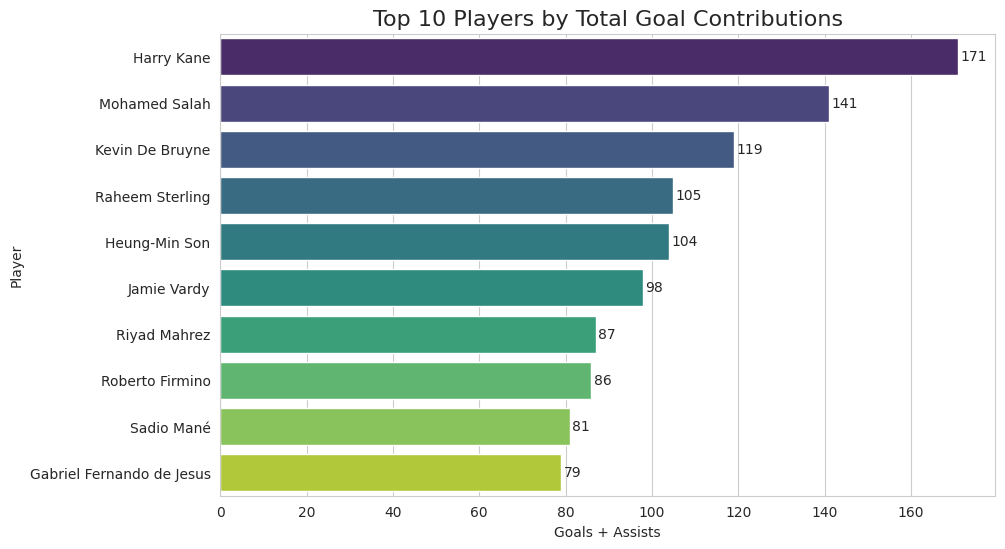

In [19]:
# Aggregate total goal contributions (Goals + Assists)
goal_contrib = df.groupby('name')[['goals_scored', 'assists']].sum()
goal_contrib['G+A'] = goal_contrib['goals_scored'] + goal_contrib['assists']
top_ga = goal_contrib.sort_values('G+A', ascending=False).head(10)

plt.figure(figsize=(10,6))
ax = sns.barplot(y=top_ga.index, x=top_ga['G+A'], palette='viridis')

# Add value labels to bars
for i, v in enumerate(top_ga['G+A']):
    ax.text(v + 0.5, i, str(int(v)), va='center', fontsize=10)

plt.title('Top 10 Players by Total Goal Contributions', fontsize=16)
plt.xlabel('Goals + Assists')
plt.ylabel('Player')
plt.show()

### Minutes Played
Shows player durability and consistency —  those with the most minutes tend to be nailed starters and key to their teams.

/tmp/ipython-input-3980712482.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_minutes.index, x=top_minutes.values, palette='coolwarm')


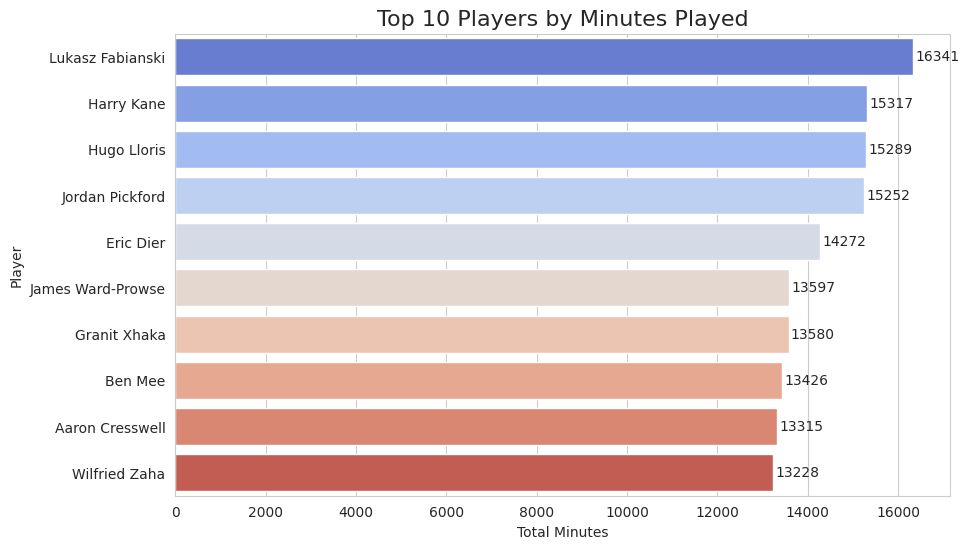

In [20]:
top_minutes = df.groupby('name')['minutes'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
ax = sns.barplot(y=top_minutes.index, x=top_minutes.values, palette='coolwarm')

# Add value labels to bars
for i, v in enumerate(top_minutes.values):
    ax.text(v + 50, i, str(int(v)), va='center', fontsize=10)

plt.title('Top 10 Players by Minutes Played', fontsize=16)
plt.xlabel('Total Minutes')
plt.ylabel('Player')
plt.show()

### Top Value Players Analysis
To evaluate player cost-effectiveness, we calculate the **average points per value unit** for each player across all gameweeks.  
The top 10 players with the highest points-to-value ratio are visualized in a bar chart to highlight those who deliver the best performance relative to their price.

/tmp/ipython-input-2695796754.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['total_points'] / x['value']).mean())
/tmp/ipython-input-2695796754.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_value_players.index, x=top_value_players.values, palette='viridis')


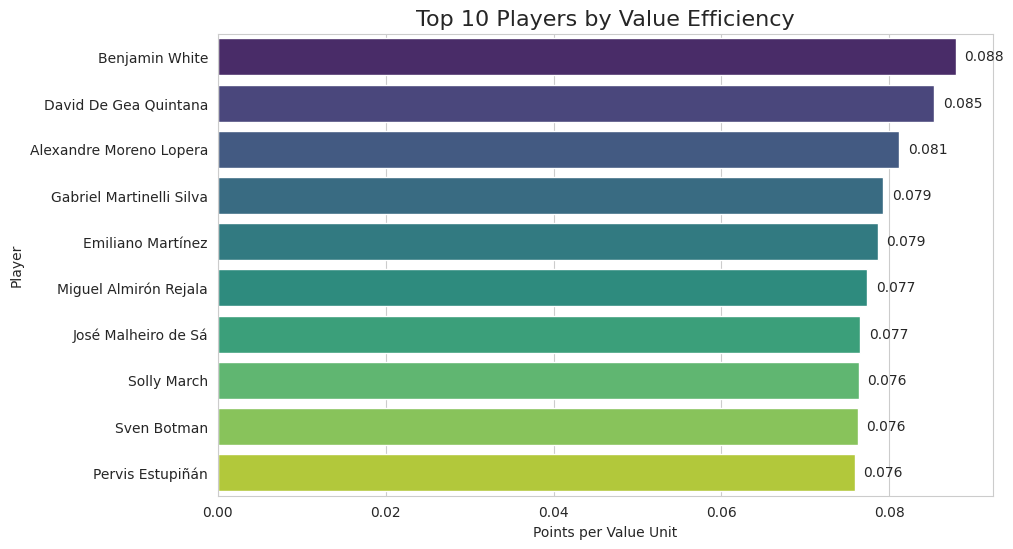

In [21]:
# Calculate top 10 players by average points per value
top_value_players = (
    df.groupby('name')
    .apply(lambda x: (x['total_points'] / x['value']).mean())
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
ax = sns.barplot(y=top_value_players.index, x=top_value_players.values, palette='viridis')

# Add value labels to bars
for i, v in enumerate(top_value_players.values):
    ax.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=10)

plt.title('Top 10 Players by Value Efficiency', fontsize=16)
plt.xlabel('Points per Value Unit')
plt.ylabel('Player')
plt.show()

### Best and Worst Performances
This identifies standout individual performances (like huge double-digit hauls) and poor performances (e.g., early red cards or own goals).


In [22]:
# Top 10 and bottom 10 performances
top_gw = df[['name', 'season_x', 'GW', 'total_points']].nlargest(10, 'total_points')
low_gw = df[['name', 'season_x', 'GW', 'total_points']].nsmallest(10, 'total_points')

display(top_gw)
display(low_gw)

name season_x  GW  total_points
15718              Mohamed Salah  2017-18  31            29
6809                  Harry Kane  2016-17  37            24
20476              Heung-Min Son  2020-21   2            24
21591              Jack Grealish  2020-21   4            24
49096                Mason Mount  2021-22   9            24
49119              Mohamed Salah  2021-22   9            24
65974  Gabriel Fernando de Jesus  2021-22  34            24
67165            Kevin De Bruyne  2021-22  36            24
73763             Erling Haaland  2022-23   9            23
71648            Roberto Firmino  2022-23   4            22

name season_x  GW  total_points
32473             Jan Bednarek  2020-21  22            -7
20584             Kieran Gibbs  2020-21   2            -4
38170            Thiago Thiago  2020-21  30            -4
49325               Ben Gibson  2021-22   9            -4
50068         Ezri Konsa Ngoyo  2021-22  10            -4
71642             Chris Mepham  2022-23   4            -4
8658               Gary Cahill  2017-18   1            -3
17633  Konstantinos Mavropanos  2017-18  37            -3
20307      Andreas Christensen  2020-21   2            -3
32612            Jack Stephens  2020-21  22            -3

### Average Value by Position
Midfielders generally hold the highest market value, reflecting their frequent  
involvement in both goals and assists — key to fantasy scoring.


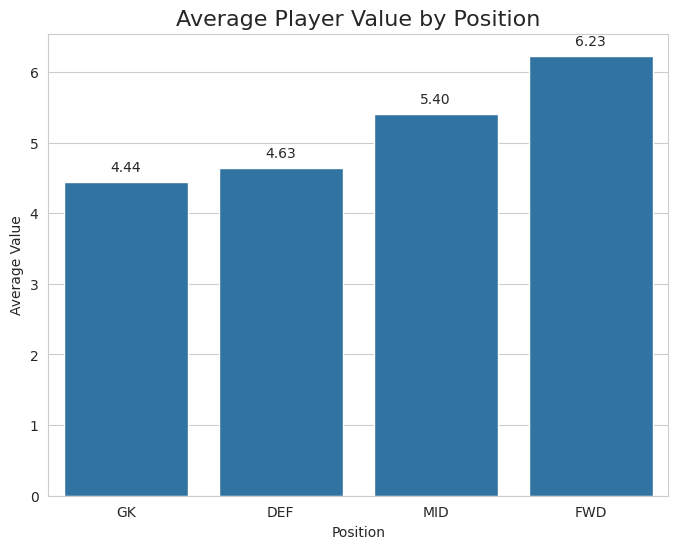

In [23]:
avg_value_pos = df.groupby('position')['value'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,6))
ax = sns.barplot(x=avg_value_pos.index, y=avg_value_pos.values/10, order=['GK', 'DEF', 'MID','FWD'])

# Add value labels to bars
for i, pos in enumerate(['GK', 'DEF', 'MID','FWD']):
    v = avg_value_pos[pos]/10
    ax.text(i, v + 0.15, f'{v:.2f}', ha='center', fontsize=10)

plt.title('Average Player Value by Position', fontsize=16)
plt.xlabel('Position')
plt.ylabel('Average Value')
plt.show()

### Correlation Matrix of All Numeric Features

This heatmap shows relationships between all numerical features in the dataset using the **Pearson correlation coefficient**.  
Red cells indicate strong positive correlations, while blue cells show negative ones.
It helps reveal how stats like **total points**, **minutes**, **ICT index**, and **BPS** relate to each other across players.


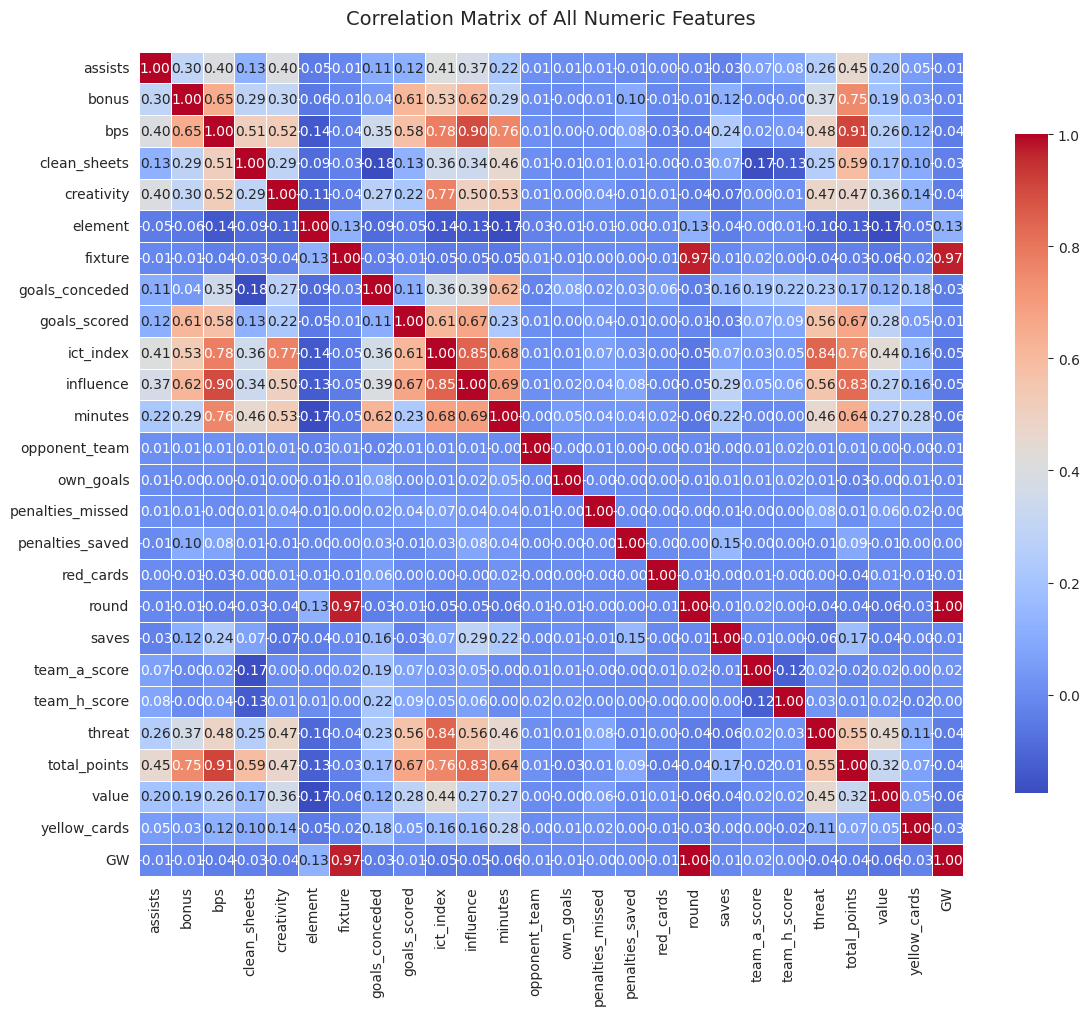

In [24]:
numeric_cols = df.select_dtypes(include=['number']).columns

# Calculate correlation matrix for all numeric columns
corr_matrix = df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

plt.title('Correlation Matrix of All Numeric Features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 5. Data-Engineering

## 5.1 Form
### Calculating Player Form Using Rolling Averages

**Goal:**  
Quantify each player's recent performance trend through a rolling average metric called **form**.

**What this step does:**  
- Sorts the dataset by `season_x`, `name`, and `GW` to ensure chronological order.  
- Calculates a 4-match rolling average of `total_points` for each player, using the previous 4 gameweeks.  
- Shifts the rolling window by one to avoid using the current game’s points in its own average (ensuring no data leakage).  
- Normalizes the result by dividing by 10 to scale the form metric.  
- Fills any missing form values with 0 and explicitly sets form to 0 for Gameweek 1 (since no prior games exist).

**Why it matters:**  
Player form captures momentum — identifying whether a player is improving or declining.  
It’s a valuable feature for predictive modeling of player performance and fantasy football analytics.


In [25]:
df = df.sort_values(['name', 'season_x', 'GW'])

df['form'] = (
    df.groupby('name')['total_points']
      .apply(lambda x: x.shift().rolling(window=4, min_periods=1).mean())
      .reset_index(level=0, drop=True)
      / 10
)

# Set form = 0 for gameweek 1
df.loc[df['GW'] == 1, 'form'] = 0
df['form'] = df['form'].fillna(0)

### Verifying Form Initialization for Gameweek 1

**Goal:**  
Ensure that all players start with a **form value of 0** in Gameweek 1, confirming that the rolling average logic is correctly implemented.

**What this step does:**  
- Filters the dataset to include only rows where `GW == 1`.  
- Extracts the unique values of the `form` column for this subset.  
- Performs a simple verification check:  
  - If all players have a `form` value of **0**, the initialization is correct.  
  - If not, it flags potential inconsistencies in the form calculation logic.

**Why it matters:**  
This validation confirms that the **form metric starts at a neutral baseline (0)** for every player, ensuring consistency across all seasons.  
It prevents data leakage from future matches and maintains the integrity of rolling form calculations.


In [26]:
# Filter the DataFrame for all rows where the Gameweek is 1
gw1_data = df[df['GW'] == 1]

# Get the unique values from the 'form' column for this filtered data
unique_forms_in_gw1 = gw1_data['form'].unique()

print(f"The unique 'form' values for all players in Gameweek 1 are: {unique_forms_in_gw1}")

# You can also add a simple test to confirm
if len(unique_forms_in_gw1) == 1 and unique_forms_in_gw1[0] == 0:
    print("\nVerification successful: All players correctly have a form of 0 in Gameweek 1.")
else:
    print("\nVerification failed: Some players do not have a form of 0 in Gameweek 1.")

The unique 'form' values for all players in Gameweek 1 are: [0.]

Verification successful: All players correctly have a form of 0 in Gameweek 1.


### 5.1 Question 2.a Top scoring position on average
**Goal:**  
Compare how different player positions — Midfielders (MID), Forwards (FWD), Defenders (DEF), and Goalkeepers (GK) — contribute to total points across seasons.

**What this step does:**  
- Groups the dataset by `season_x` and `position` to calculate the total points scored by each position every season.  
- Computes the **average total points** per position across all seasons to identify consistent top performers.  
- Visualizes the results using a bar chart, ordering positions as `MID`, `FWD`, `DEF`, and `GK` for clarity.

**Why it matters:**  
This analysis reveals how player roles impact their overall fantasy value:  
- **Midfielders** and **Forwards** typically earn the most points due to their attacking involvement.  
- **Defenders** and **Goalkeepers** score fewer points, reflecting their defensive responsibilities.  
- Understanding these trends helps in **feature importance**, **model weighting**, and **team composition strategies** in fantasy football analytics.

/tmp/ipython-input-1466095780.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_points_by_position.index, y=avg_points_by_position.values, palette='viridis')


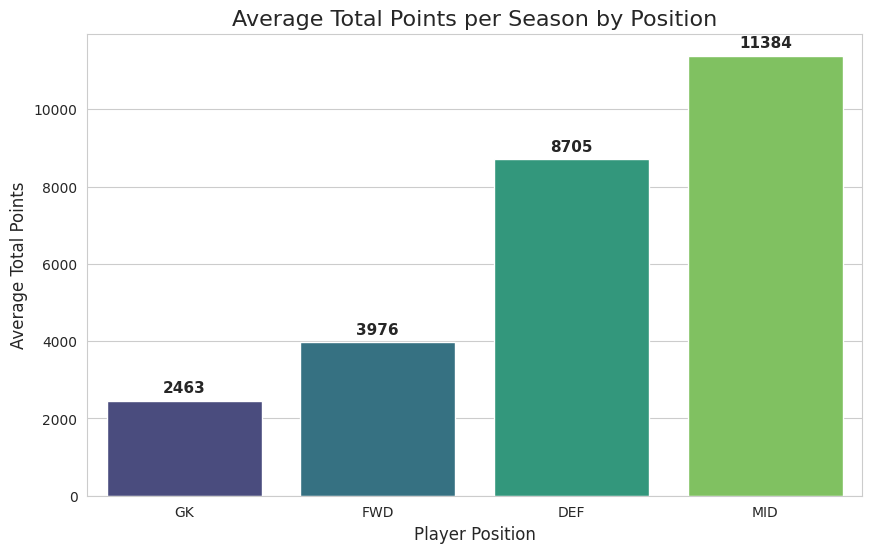

In [27]:
avg_points_by_position = df.groupby(['season_x', 'position'])['total_points'].sum().groupby('position').mean().sort_values(ascending=True)
# Set the style for the plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the bar plot
ax = sns.barplot(x=avg_points_by_position.index, y=avg_points_by_position.values, palette='viridis')

# Add a title and labels
ax.set_title('Average Total Points per Season by Position', fontsize=16)
ax.set_xlabel('Player Position', fontsize=12)
ax.set_ylabel('Average Total Points', fontsize=12)

# Add data labels on top of each bar for clarity
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=11,
                fontweight='bold')

# Show the plot
plt.show()

### 5.1 Question 2.b Top 5 players form
**Goal:**  
Identify the top-performing players of the 2022–23 season and examine how their form evolved throughout the campaign.

**What this step does:**  
- Filters the dataset to include only records from the **2022–23** season.  
- Determines the **top 5 players by total points** to capture consistent season-long performers.  
- Identifies the **top 5 players by peak form**, representing players who reached the highest short-term performance levels.  
- Visualizes the **form evolution** of the top 5 form players across all gameweeks using a line plot.

**Why it matters:**  
This analysis provides insights into player consistency and momentum:  
- **Top total points players** highlight season-long reliability.  
- **Top peak form players** capture short bursts of exceptional performance.  
- Tracking **form trends** over time helps understand how player performance fluctuates, which is crucial for forecasting and strategic fantasy team management.

In [28]:
top_points = df[df['season_x'] == '2022-23'].groupby('name').sum('total_points').sort_values('total_points', ascending=False)

top_form = df[df['season_x'] == '2022-23'].sort_values(by='form', ascending=False)
top_form = (
    top_form
      .drop_duplicates(subset=['name'], keep='first')
)

top_points_names = top_points.head(5).index.to_list()
top_form_names = top_form['name'].head(5).to_list()

names_array = list(dict.fromkeys(top_points_names + top_form_names))

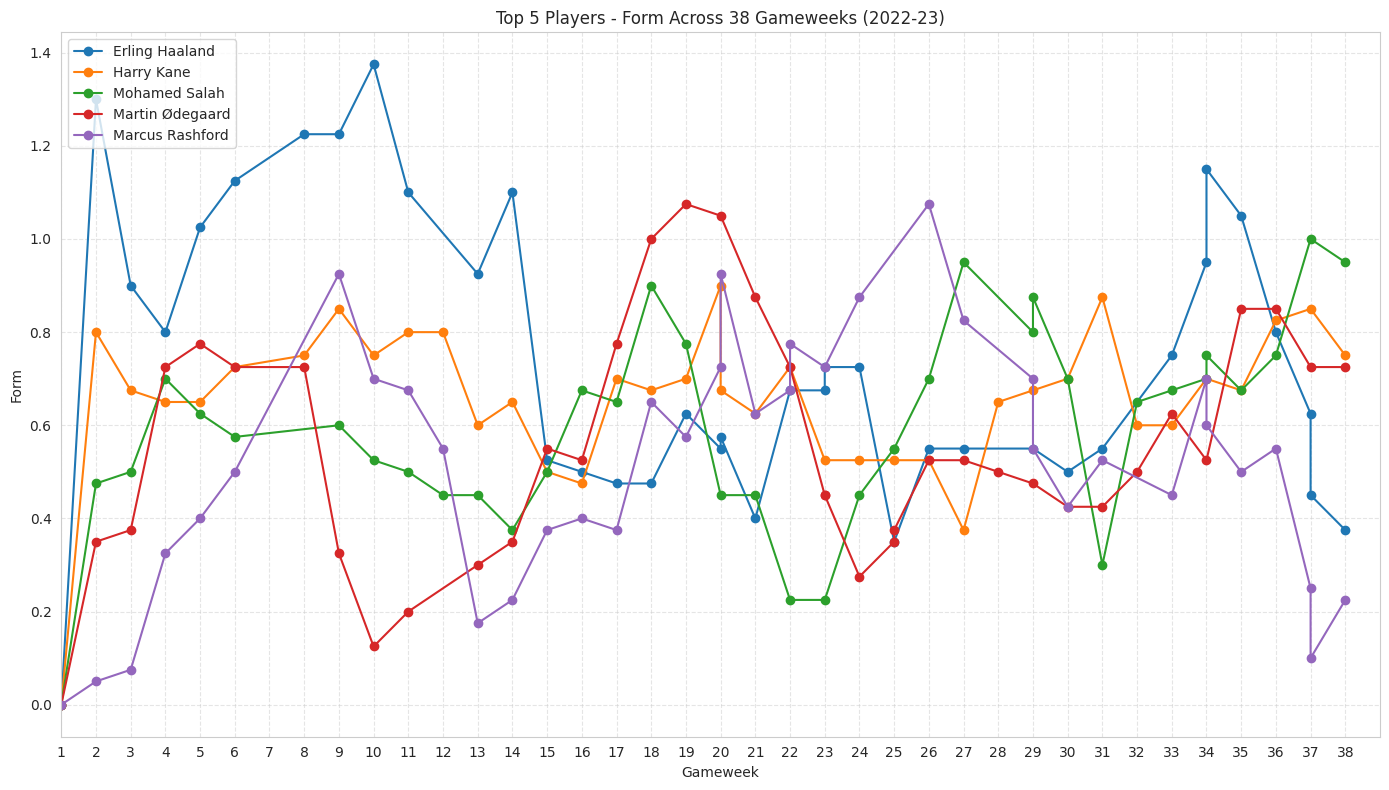

In [29]:
# Prepare x axis (gameweeks 1 to 38)
gameweeks = np.arange(1, 39)

plt.figure(figsize=(14, 8))

# Plot each player's form across the 38 gameweeks
for name in top_points_names:
    player_data = df[(df['season_x'] == '2022-23') & (df['name'] == name)]
    player_data = player_data.sort_values('GW')  # assuming 'event' column = gameweek number

    plt.plot(player_data['GW'], player_data['form'], marker='o', label=name)


# Chart styling
plt.xlabel('Gameweek')
plt.ylabel('Form')
plt.title('Top 5 Players - Form Across 38 Gameweeks (2022-23)')
plt.xticks(gameweeks)
plt.xlim(1, 39)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 5.1 Question 2.c Are the top players in form the same top players with the highest total points?
### Visualizing the Relationship Between Form and Total Points  

**Goal:**  
Examine how a player’s **recent form** correlates with their **total points** in a season, focusing on top performers.  

**What this step does:**  
- Prepares `x` and `y` arrays:  
  - `x`: Latest **form** values of the top players.  
  - `y`: **Total points** scored by those players in the season.  
- Creates a **scatter plot** to visualize the relationship.  
- Annotates each point with the corresponding **player name** for easy identification.  
- Adds grid, labels, and a title for clarity.  

**Why it matters:**  
- Helps identify whether high-form players are consistently translating their recent performance into points.  
- Provides intuitive, visual insight for feature importance and predictive modeling considerations.


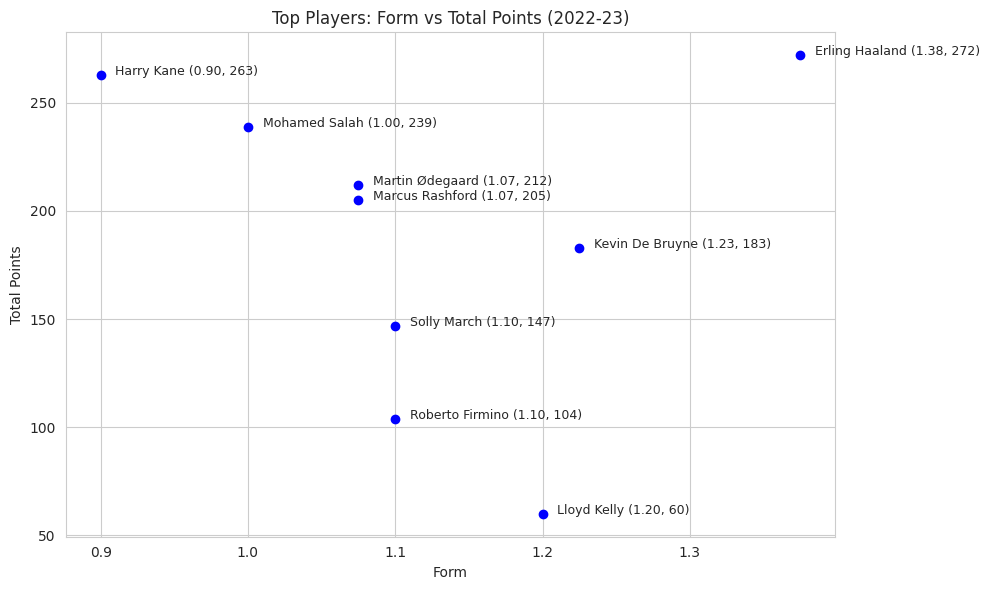

In [30]:
# Prepare x and y data
x = []  # form
y = []  # total_points

for name in names_array:
    # Get form value from top_form
    form_value = top_form.loc[top_form['name'] == name, 'form'].values[0]

    # Get total_points value from top_points
    total_points_value = top_points.loc[name, 'total_points']

    x.append(form_value)
    y.append(total_points_value)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue')

# Annotate each point with the player name
for i, name in enumerate(names_array):
  # ---- THIS IS THE MODIFIED LINE ----
    # We format the text to include the name, form (rounded to 2 decimal places), and total points
    annotation_text = f"{name} ({x[i]:.2f}, {y[i]})"
    plt.text(x[i] + 0.01, y[i], annotation_text, fontsize=9)

# Labels and title
plt.xlabel('Form')
plt.ylabel('Total Points')
plt.title('Top Players: Form vs Total Points (2022-23)')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Analysis: Are the top players in form the same as the top players in total points?**

### **Conclusion**
No, the top players in form are not the same as the top players with the highest total_points.

As the scatter plot visually demonstrates, the players with the highest form (those furthest to the right on the x-axis) are not necessarily the same players with the highest total_points (those highest on the y-axis).

A player might accumulate a massive total_points score over the entire 38-gameweek season (like Harry Kane), but their form (which we defined as a 4-week rolling average) might be lower than a different player who had a shorter, more explosive period of high performance during the season. This confirms that while the two metrics are related, they measure different aspects of performance.

### Saving the Cleaned Dataset  

**Goal:**  
Export the finalized dataset to a CSV file for future analysis, modeling, or sharing.  

**What this step does:**  
- Saves the cleaned and feature-engineered DataFrame (`df`) to a CSV file named **`cleaned_fpl_data.csv`**.  
- Excludes the DataFrame’s index to maintain a clean tabular format.  
- Displays a success message confirming the operation.  

**Why it matters:**  
Saving the processed data ensures that all cleaning, transformations, and feature engineering steps are preserved for later use.  
This allows you to skip preprocessing in future sessions — enabling direct loading of ready-to-model data for experimentation or deployment.


In [31]:
# Save cleaned DataFrame to CSV
df.to_csv('cleaned_fpl_data.csv', index=False)

print("✅ Cleaned data saved successfully to 'cleaned_fpl_data.csv'")

✅ Cleaned data saved successfully to 'cleaned_fpl_data.csv'


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96169 entries, 19852 to 43705
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   season_x          96169 non-null  object             
 1   name              96169 non-null  object             
 2   position          96169 non-null  object             
 3   team_x            96169 non-null  object             
 4   assists           96169 non-null  int64              
 5   bonus             96169 non-null  int64              
 6   bps               96169 non-null  int64              
 7   clean_sheets      96169 non-null  int64              
 8   creativity        96169 non-null  float64            
 9   element           96169 non-null  int64              
 10  fixture           96169 non-null  int64              
 11  goals_conceded    96169 non-null  int64              
 12  goals_scored      96169 non-null  int64              
 13  ic

# 6. Predictive Modeling Task

### Creating the Target Variable: *Upcoming Total Points*

**Goal:**  
Prepare a **target variable** that represents each player's total points in the *next gameweek*, enabling predictive modeling of future performance.

**What this step does:**  
- Sorts the dataset by `season_x`, `name`, and `GW` to ensure chronological order.  
- Uses `groupby` and `shift(-1)` to create a new column, **`upcoming_total_points`**, which contains the player’s total points from the *following* gameweek.  
- Drops the final gameweek of each season for every player, since those rows have no “next gameweek” value (resulting in `NaN`).  
- Verifies the result using a sample player (e.g., *Harry Kane*) to confirm that the shifting logic is correct.

**Why it matters:**  
This transformation is crucial for supervised learning — it turns the dataset into a **predictive structure**, where current statistics and features (e.g., form, team strength) can be used to forecast *next gameweek performance*.  
It ensures temporal consistency by preventing the use of future data in model training.


In [33]:
# First, ensure the data is sorted chronologically for each player within each season
df.sort_values(by=['season_x', 'name', 'GW'], inplace=True)

# Group by player and season, then shift the 'total_points' up by one
# This creates our target variable: upcoming_total_points
df['upcoming_total_points'] = df.groupby(['season_x', 'name'])['total_points'].shift(-1)

# The last gameweek for each player in each season now has a NaN value.
# We will drop these rows as they cannot be used for training.
print(f"Shape before dropping final gameweek: {df.shape}")
df.dropna(subset=['upcoming_total_points'], inplace=True)
print(f"Shape after dropping final gameweek:  {df.shape}")

# Let's verify for a player
print("\nVerifying the new 'upcoming_total_points' column for Harry Kane:")
print(df[df['name'] == 'Harry Kane'][['GW', 'total_points', 'upcoming_total_points']].head().to_string())

Shape before dropping final gameweek: (96169, 35)
Shape after dropping final gameweek:  (93387, 35)

Verifying the new 'upcoming_total_points' column for Harry Kane:
      GW  total_points  upcoming_total_points
70     1             2                    5.0
2475   2             5                    2.0
4811   3             2                    6.0
7361   4             6                    9.0
7574   5             9                    0.0


## 6.1 Defining Features and Target Variable For LightGBM

**Goal:**  
Prepare the **input features** and **target variable** for predictive modeling of player performance.

**What this step does:**  
- Defines **`upcoming_total_points`** as the target variable, representing how many points a player will earn in the *next gameweek*.  
- Selects a meaningful set of predictive features that capture player ability, recent form, and match context:  
  - `minutes`: Player’s playing time in the current gameweek.    
  - `bps`: Bonus Points System score (a measure of in-game performance).  
  - `ict_index`: Influence, Creativity, and Threat index (a key fantasy metric).  
  - `was_home`: Indicates whether the player played at home or away.  
  - `form`: Player’s recent 4-game performance trend.  
  - `position`: Player’s role (GK, DEF, MID, FWD).

**Why it matters:**  
Defining these features and the target variable creates the foundation for **machine learning modeling**.  
The selected variables combine both *player-specific* and *contextual* information, helping the model learn how situational and historical factors influence future performance.


In [34]:
# Define our target variable
target = 'upcoming_total_points'

# Select our predictive features from the prepared DataFrame
features = ['goals_scored', 'goals_conceded', 'own_goals', 'penalties_missed', 'penalties_saved', 'saves', 'minutes', 'assists', 'clean_sheets', 'bonus', 'bps', 'was_home', 'yellow_cards', 'red_cards',
      'position', 'creativity', 'influence', 'form', 'ict_index', 'threat']
# Create our feature matrix (X) and target vector (y)
X = df[features]
y = df[target]

print("Features and target have been defined successfully.")
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")

Features and target have been defined successfully.
Shape of feature matrix X: (93387, 20)
Shape of target vector y: (93387,)


### Splitting Data into Training and Test Sets

**Goal:**  
Separate the dataset into **training** and **testing** subsets to evaluate model performance on unseen data.

**What this step does:**  
- Uses all seasons **before 2022-23** as the **training set** — this allows the model to learn patterns from historical data.  
- Uses the **2022-23 season** as the **test set** — representing new, unseen data to assess how well the model generalizes.  
- Extracts the defined **features** (`X_train`, `X_test`) and **target variable** (`y_train`, `y_test`) for both subsets.

**Why it matters:**  
By isolating the most recent season for testing, we simulate a **real-world prediction scenario**, where the model predicts future performance based on past seasons.  
This temporal separation prevents data leakage and ensures a fair, time-aware evaluation of the model’s predictive power.


In [35]:
# The most recent season in our dataset is 2022-23, which will be our test set.
test_season = '2022-23'

# Create the training set (all seasons EXCEPT the test season)
train_df = df[df['season_x'] != test_season]
X_train = train_df[features]
y_train = train_df[target]

# Create the test set (ONLY the test season)
test_df = df[df['season_x'] == test_season]
X_test = test_df[features]
y_test = test_df[target]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape:     {X_test.shape}")

Training set shape: (67659, 20)
Test set shape:     (25728, 20)


### Building the LightGBM Modeling Pipeline

**Goal:**  
Prepare a machine learning pipeline that preprocesses data and trains a predictive model for player performance.

**What this step does:**  
- **Identifies feature types:**  
  - `categorical_features`: Columns like `position` that represent categories.  
  - `numerical_features`: Continuous numerical variables (e.g., minutes, form,ict_index).  
- **Uses a `ColumnTransformer`:**  
  - Applies **One-Hot Encoding** to categorical features, converting them into numeric form suitable for modeling.  
  - Passes through numerical features unchanged.  
- **Initializes the model:**  
  - Employs **LightGBM (LGBMRegressor)** — a fast, gradient-boosted decision tree algorithm known for high efficiency and performance on structured data.  
- **Creates a unified pipeline:**  
  - Combines preprocessing and model training into a single, reproducible workflow for easier scaling and consistent transformations.

**Why it matters:**  
This pipeline ensures **clean, automated preprocessing** and **consistent model training**, minimizing human error.  
By integrating encoding and modeling, it becomes easier to test, retrain, and deploy models without redoing preprocessing steps manually.


**Key advantages of LightGBM over other models:**  
1. **Speed and Efficiency:**  
   - Trains significantly faster than traditional gradient boosting libraries (like XGBoost or CatBoost) due to optimized histogram-based algorithms.  
2. **High Accuracy:**  
   - Achieves state-of-the-art results in regression and classification tasks by using leaf-wise tree growth, which allows for deeper, more specialized trees.  
3. **Handles Large Datasets Well:**  
   - Efficient memory usage makes it scalable to tens of thousands of samples and features.  
4. **Automatic Handling of Missing Values:**  
   - LightGBM can internally manage missing data, which reduces preprocessing complexity.  
5. **Support for Categorical Features:**  
   - Can natively handle categorical data (or easily integrate with encoders), making it ideal for mixed data types.  
6. **Excellent Generalization:**  
   - Regularization parameters and flexible boosting options help prevent overfitting, improving performance on unseen data.


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import lightgbm as lgb

# Define which columns are categorical and which are numerical
categorical_features = ['position']
numerical_features = [col for col in features if col not in categorical_features]

# Create a preprocessor object using ColumnTransformer
# It will apply OneHotEncoder to categorical features and do nothing to numerical ones.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define our model
lgbm = lgb.LGBMRegressor(random_state=42)

# Create the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', lgbm)])

print("Model pipeline created successfully.")

Model pipeline created successfully.


### Training the LightGBM Model

**Goal:**  
Fit the prepared pipeline to the training data, allowing the model to learn relationships between player statistics and their upcoming performance.

**What this step does:**  
- Calls the `.fit()` method on the **`model_pipeline`**, which:  
  1. Applies all preprocessing steps defined earlier (e.g., encoding categorical variables).  
  2. Trains the **LightGBM regressor** on the processed training data (`X_train`, `y_train`).  
- Displays progress messages to confirm the start and completion of training.

**Why it matters:**  
This is the core learning phase of the workflow — where the model builds its understanding of how player metrics (like form and minutes) influence future points.  
By training through the pipeline, all transformations remain consistent and automatically applied during both training and prediction.


In [37]:
# Train the pipeline
print("Training the LightGBM model...")
model_pipeline.fit(X_train, y_train)
print("Training complete.")

Training the LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1194
[LightGBM] [Info] Number of data points in the train set: 67659, number of used features: 23
[LightGBM] [Info] Start training from score 1.449859
Training complete.


### Saving the LightGBM model

In [77]:
import joblib
import os

# --- 1. Create an 'exports' folder ---
# This line is from your example and is perfect.
os.makedirs("exports", exist_ok=True)

# --- 2. Define the filename ---
pipeline_filename = "exports/lgbm_model_pipeline.joblib"

# --- 3. Save the 'model_pipeline' object ---
# This is the variable from your Section 6.1.2
joblib.dump(model_pipeline, pipeline_filename)

print(f"LGBM model pipeline saved successfully to: {pipeline_filename}")

LGBM model pipeline saved successfully to: exports/lgbm_model_pipeline.joblib


### Evaluating the Model on the Unseen 2022–23 Season

**Goal:**  
Assess how well the trained model generalizes to new, unseen data (the **2022–23 season**) to ensure it hasn’t just memorized past patterns.

**What this step does:**  
- Uses the trained **`model_pipeline`** to generate predictions (`y_pred`) for the test set (`X_test`).  
- Calculates several key **regression metrics** to evaluate prediction accuracy:  
  1. **Mean Absolute Error (MAE):** Average magnitude of prediction errors.  
  2. **Mean Squared Error (MSE):** Penalizes larger errors more heavily.  
  3. **Root Mean Squared Error (RMSE):** Error magnitude in the same units as the target variable.  
  4. **R-squared (R²):** Proportion of variance in the target explained by the model.  
- Prints the results to summarize model performance.

**Why it matters:**  
This step verifies whether the model can **generalize** to a new season instead of just fitting to historical data.  
Lower error values and a higher R² indicate that the model effectively captures the relationship between player stats and performance in unseen conditions.


In [38]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
print("Evaluating the model on the unseen 2022-23 season...")
y_pred = model_pipeline.predict(X_test)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation Results ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Evaluating the model on the unseen 2022-23 season...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- Model Evaluation Results ---
Mean Absolute Error (MAE): 1.0868
Mean Squared Error (MSE):  3.9461
Root Mean Squared Error (RMSE): 1.9865
R-squared (R²): 0.2908


## 6.2 Model 2: Neural Network (nn_model1)

### Define Features and Use Split Data (by Season)



1.   First, we define the features for this model.
2.   We'll use the 21 features (the 20 from LGBM + 'value').




In [39]:
# Imports for the new model
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf

In [40]:
!pip install scikeras

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [42]:
# # Install the modern wrapper for Keras and Scikit-Learn
# !pip install scikeras

In [43]:
# --- 1. Define the new feature list ---
# We use your original 'features' list and add 'value'
nn_features_1 = features + ['value']
print(f"Total features for NN Model 1: {len(nn_features_1)}")

Total features for NN Model 1: 21


In [44]:
# --- 2. Create new X/y variables from the existing train_df and test_df ---
# This ensures the split is identical (same rows)
X_train_nn_1 = train_df[nn_features_1]
y_train_nn_1 = train_df[target] # y_train is the same

X_test_nn_1 = test_df[nn_features_1]
y_test_nn_1 = test_df[target]   # y_test is the same

print(f"NN Model 1 training data shape: {X_train_nn_1.shape}")
print(f"NN Model 1 testing data shape: {X_test_nn_1.shape}")

NN Model 1 training data shape: (67659, 21)
NN Model 1 testing data shape: (25728, 21)


### Create the NN Preprocessor

In [45]:
# --- 1. Define categorical and numerical features for the NN ---
# (This assumes nn_model2 will use the same 21-feature list)
nn_categorical_features = ['position']
nn_numerical_features = [
    col for col in nn_features_1
    if col not in nn_categorical_features
]

# --- 2. Create the transformers ---
numeric_transformer_nn = StandardScaler()
categorical_transformer_nn = OneHotEncoder(handle_unknown='ignore')

# --- 3. Build the general-purpose NN preprocessor ---
# We give it a general name to reuse it for nn_model2
nn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_nn, nn_numerical_features),
        ('cat', categorical_transformer_nn, nn_categorical_features)
    ]
)

print("General NN Preprocessor created successfully.")
print(f"It will scale {len(nn_numerical_features)} numerical features.")
print(f"It will one-hot encode {len(nn_categorical_features)} categorical feature.")

General NN Preprocessor created successfully.
It will scale 20 numerical features.
It will one-hot encode 1 categorical feature.


### Process the Train and Test Data

In [46]:
# --- 1. Fit the preprocessor on the training data and transform it ---
print("Preprocessing the training data...")
X_train_nn_1_processed = nn_preprocessor.fit_transform(X_train_nn_1)

# --- 2. Only transform the test data ---
print("Preprocessing the testing data...")
X_test_nn_1_processed = nn_preprocessor.transform(X_test_nn_1)

# --- 3. Get the output shape for the model ---
# This is now simple and bug-free
total_features_out = X_train_nn_1_processed.shape[1]

print(f"Preprocessor created {total_features_out} features.")
print(f"Processed training data shape: {X_train_nn_1_processed.shape}")
print(f"Processed testing data shape: {X_test_nn_1_processed.shape}")

Preprocessing the training data...
Preprocessing the testing data...
Preprocessor created 24 features.
Processed training data shape: (67659, 24)
Processed testing data shape: (25728, 24)


### --- 1. Define the Keras Model Architecture ---

In [47]:
def build_nn_model1(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    return model

### --- 2. Build the Model ---

In [48]:
# --- 2. Build the Model ---
nn_model1 = build_nn_model1(total_features_out)
nn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545 (2.13 KB)

 Trainable params: 545 (2.13 KB)

 Non-trainable params: 0 (0.00 B)

### --- Train the Model ---

In [49]:
# --- 3. Define Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- 4. Train the Model ---
print("\nTraining NN Model 1...")
history = nn_model1.fit(
    X_train_nn_1_processed,  # Use the new processed data
    y_train_nn_1,
    epochs=200,
    batch_size=32,
    verbose=1,
    validation_split=0.2,    # Keras handles the validation split for us
    callbacks=[early_stop]
)


Training NN Model 1...
Epoch 1/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 6.0144 - mae: 1.3767 - val_loss: 4.3295 - val_mae: 1.1218
Epoch 2/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 5.1394 - mae: 1.3244 - val_loss: 4.2950 - val_mae: 1.1433
Epoch 3/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 5.0262 - mae: 1.3121 - val_loss: 4.3087 - val_mae: 1.1601
Epoch 4/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 5.0497 - mae: 1.3220 - val_loss: 4.2807 - val_mae: 1.1311
Epoch 5/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 5.0471 - mae: 1.3281 - val_loss: 4.2780 - val_mae: 1.1200
Epoch 6/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.9548 - mae: 1.3019 - val_loss: 4.2814 - val_mae: 1.1151
Epoch 7/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 5.1006 - mae: 1.3241 - val_loss: 4.3001 - val_mae: 1.0980
Epoch 8/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.1291 - mae: 1.3243 - val_loss: 4.3024 - val_mae: 1.1420
Epoc

### Saving NN Model 1

In [78]:
# --- Save nn_model1 (Keras) ---
# Note: This saves ONLY the trained model, not the 'nn_preprocessor'.
# This is why saving the 'joblib' pipeline is better for inference.
nn_model1.save("exports/nn_model1.h5")

print("nn_model1 Keras model saved successfully to: exports/nn_model1.h5")

nn_model1 Keras model saved successfully to: exports/nn_model1.h5


### --- Evaluate the Model ---

In [50]:
# --- 5. Evaluate the Model ---
print("\nEvaluating model on the test set...")
# Use the processed test data
y_pred_nn1 = nn_model1.predict(X_test_nn_1_processed)

# --- 6. Calculate Metrics ---
mae_nn1 = mean_absolute_error(y_test_nn_1, y_pred_nn1)
mse_nn1 = mean_squared_error(y_test_nn_1, y_pred_nn1)
rmse_nn1 = np.sqrt(mse_nn1)
r2_nn1 = r2_score(y_test_nn_1, y_pred_nn1)

print("\n--- NN Model 1 Evaluation Results ---")
print(f"Mean Absolute Error (MAE): {mae_nn1:.4f}")
print(f"Mean Squared Error (MSE): {mse_nn1:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn1:.4f}")
print(f"R-squared (R²): {r2_nn1:.4f}")
print("-------------------------------------")


Evaluating model on the test set...
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  

--- NN Model 1 Evaluation Results ---
Mean Absolute Error (MAE): 1.0526
Mean Squared Error (MSE): 3.8692
Root Mean Squared Error (RMSE): 1.9670
R-squared (R²): 0.3046
-------------------------------------


## 6.3 Model 3: Neural Network (nn_model2)

In [51]:
# --- 1. Define the Keras Model Architecture for Model 2 ---
def build_nn_model2(input_shape):
    """
    Defines the architecture for our second NN model.
    Let's try a wider, "rectangle" shape: 32 -> 32.
    """
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(32, activation='relu'), # A wider first layer
        Dense(32, activation='relu'), # A second layer of the same size
        Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    return model

In [52]:
# --- 2. Build the Model ---
# We use the 'total_features_out' (24) variable from the previous step
nn_model2 = build_nn_model2(total_features_out)
print("Model Architecture (nn_model2):")
nn_model2.summary()

Model Architecture (nn_model2):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,889 (7.38 KB)

 Trainable params: 1,889 (7.38 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# --- 3. Train the Model ---
print("\nTraining NN Model 2...")
# We can reuse the 'early_stop' callback defined in the previous section
history_nn2 = nn_model2.fit(
    X_train_nn_1_processed,  # Use the SAME processed training data
    y_train_nn_1,
    epochs=200,
    batch_size=32,
    verbose=1,
    validation_split=0.2,
    callbacks=[early_stop]   # Reuse the same early stopping criteria
)


Training NN Model 2...
Epoch 1/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.6122 - mae: 1.3779 - val_loss: 4.3233 - val_mae: 1.0762
Epoch 2/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.1473 - mae: 1.3225 - val_loss: 4.2972 - val_mae: 1.0937
Epoch 3/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.9437 - mae: 1.2965 - val_loss: 4.3138 - val_mae: 1.0879
Epoch 4/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.1759 - mae: 1.3278 - val_loss: 4.3033 - val_mae: 1.1409
Epoch 5/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.1543 - mae: 1.3312 - val_loss: 4.3879 - val_mae: 1.2561
Epoch 6/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.9811 - mae: 1.3076 - val_loss: 4.3273 - val_mae: 1.2280
Epoch 7/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.1709 - mae: 1.3342 - val_loss: 4.3172 - val_mae: 1.1313
Epoch 8/200
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.0903 - mae: 1.3238 - val_loss: 4.3089 - val_mae: 1.1170
Epoch 9/

In [54]:
# --- 4. Evaluate the Model ---
print("\nEvaluating model 2 on the test set...")
y_pred_nn2 = nn_model2.predict(X_test_nn_1_processed) # Use the SAME processed test data

# --- 5. Calculate Metrics ---
# Note: Using new variable names for the metrics (e.g., mae_nn2)
mae_nn2 = mean_absolute_error(y_test_nn_1, y_pred_nn2)
mse_nn2 = mean_squared_error(y_test_nn_1, y_pred_nn2)
rmse_nn2 = np.sqrt(mse_nn2)
r2_nn2 = r2_score(y_test_nn_1, y_pred_nn2)

print("\n--- NN Model 2 Evaluation Results ---")
print(f"Mean Absolute Error (MAE): {mae_nn2:.4f}")
print(f"Mean Squared Error (MSE): {mse_nn2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn2:.4f}")
print(f"R-squared (R²): {r2_nn2:.4f}")
print("-------------------------------------")


Evaluating model 2 on the test set...
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  

--- NN Model 2 Evaluation Results ---
Mean Absolute Error (MAE): 1.0261
Mean Squared Error (MSE): 3.8816
Root Mean Squared Error (RMSE): 1.9702
R-squared (R²): 0.3024
-------------------------------------


# 7. Model Explainability (XAI)



In this section, we apply explainable AI techniques to understand our LightGBM model's behavior. As required by the project, we will use SHAP to interpret the predictions and identify the most influential features.

## 7.1 SHAP (SHapley Additive exPlanations) (LightGBM)
SHAP is a game-theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory.

### 7.1.1 Installing and Importing SHAP
First, we need to ensure the shap library is installed in our Colab environment.

In [55]:
!pip install shap

In [56]:
import shap

# Initialize the JavaScript visualization for SHAP plots
shap.initjs()

### 7.1.2 Global Feature Importance (Summary Plot)
We will start by creating a SHAP TreeExplainer for our trained LightGBM model. We'll then calculate the SHAP values for our test set to see which features the model relies on most.

In [57]:
# Create a TreeExplainer object for our LightGBM model
# The model is stored in the 'model_pipeline' variable from section 6
# Extract the trained LightGBM model from the pipeline
lgbm_model = model_pipeline.named_steps['regressor']
explainer = shap.TreeExplainer(lgbm_model)

# Apply the same preprocessing as the pipeline to X_test
X_test_processed = model_pipeline.named_steps['preprocessor'].transform(X_test)

# Calculate SHAP values for the test set
# This can take a moment
shap_values = explainer.shap_values(X_test_processed)

High Feature Value (Red dots): Shows the effect when a feature has a high value.

Low Feature Value (Blue dots): Shows the effect when a feature has a low value.

Horizontal Axis: The SHAP value. Positive values push the prediction higher (more points), while negative values push it lower.

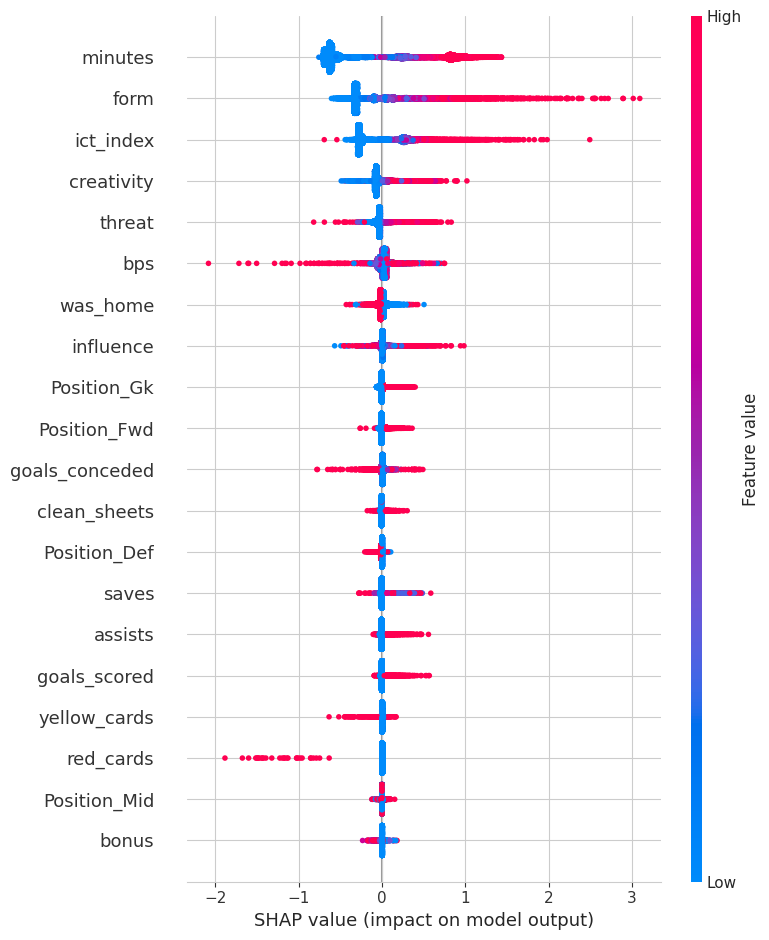

In [58]:
# Create a SHAP summary plot
# This plot shows the most important features at the top
# and the distribution of their impact.

# Get the feature names after preprocessing
processed_feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out(features)

# Create a list of simplified feature names
simplified_feature_names = []
for name in processed_feature_names:
    if name.startswith('num__'):
        # Remove the 'num__' prefix
        simplified_feature_names.append(name[5:])
    elif name.startswith('cat__position_'):
        # Remove the 'cat__position_' prefix and capitalize
        simplified_feature_names.append('Position_' + name[14:].capitalize())
    else:
        # Keep other names as they are (shouldn't be any in this case)
        simplified_feature_names.append(name)


shap.summary_plot(shap_values, X_test_processed, feature_names=simplified_feature_names, title="Global Feature Importance (SHAP)")

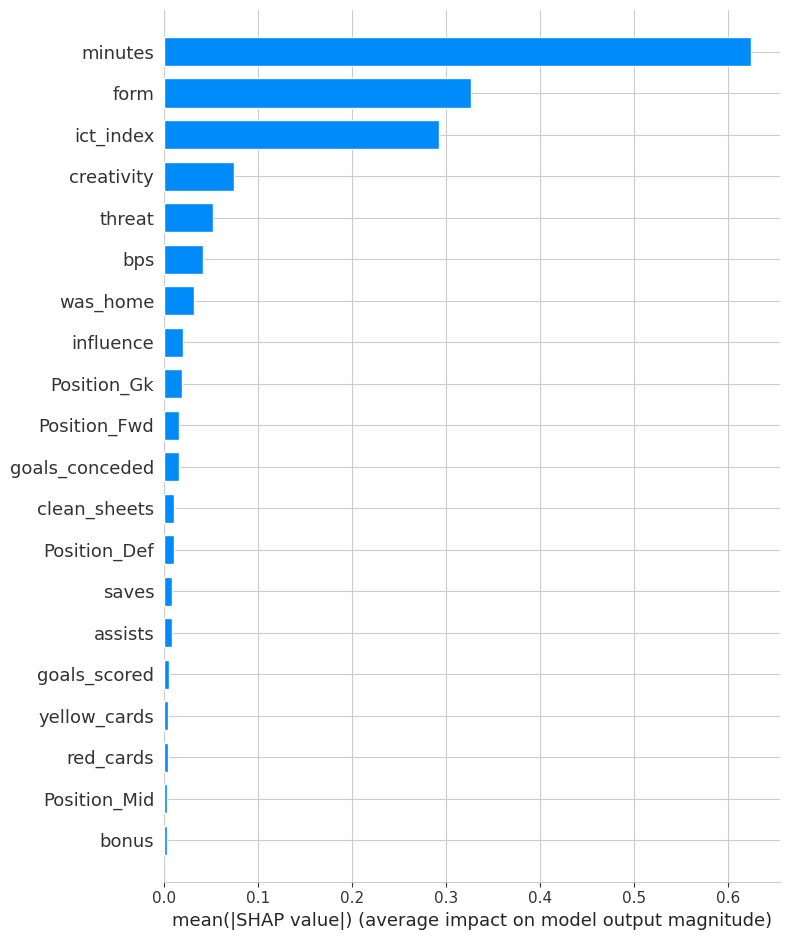

In [59]:
shap.summary_plot(shap_values, X_test_processed, feature_names=simplified_feature_names, plot_type='bar', title="Global Feature Importance (SHAP)")

### 7.1.3 Local Explanations (SHAP Force Plot)
While the summary plots show which features are important globally, a force plot shows how those features combine to create a single, specific prediction.

We will explain the first instance in our test set (`X_test`). This plot shows the "base value" (the average prediction over the dataset) and how each feature "pushes" or "pulls" the prediction away from that base to arrive at the final output.

- Red features (like form or minutes) push the prediction higher.
- Blue features push the prediction lower.

Below the plot, you'll see details about the specific player instance being explained.

In [60]:
# Create a DataFrame from the processed test data for easier plotting
# We use the simplified feature names we created earlier
X_test_processed_df = pd.DataFrame(X_test_processed, columns=simplified_feature_names)

# Define the index of the instance you want to explain
i = 11901 # Change this index to explore different instances

# Get the details of the instance from the original test_df
instance_details = test_df.iloc[i]

# Print the details of the player instance being explained
print(f"Explaining prediction for: {instance_details['name']}")
print(f"Season: {instance_details['season_x']}")
print(f"Gameweek: {instance_details['GW']}")
print(f"Team: {instance_details['team_x']}")
print(f"Opponent Team: {instance_details['opp_team_name']}")
print(f"Actual Total Points (Next GW): {instance_details['upcoming_total_points']}")
print("-" * 30)


# Explain the prediction for the selected instance in the test set
# We use explainer.expected_value (the model's average prediction)
# shap_values[i,:] (the SHAP values for the i-th instance)
# X_test_processed_df.iloc[i,:] (the feature values for the i-th instance)
shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values[i],
                X_test_processed_df.iloc[i],
                link="identity") # Use "identity" link for regression

Explaining prediction for: John Stones
Season: 2022-23
Gameweek: 37
Team: Man City
Opponent Team: Chelsea
Actual Total Points (Next GW): 2.0
------------------------------


## 7.2 LIME (Local Interpretable Model-agnostic Explanations)
LIME is another popular XAI technique. Unlike SHAP (which used a special TreeExplainer), LIME is "model-agnostic," meaning it works with any model by treating it as a black box. It explains a single prediction by creating a simpler, "local" model (like linear regression) that approximates the complex model's behavior just for that one data point.



### 7.2.1 Install and Import LIME

In [61]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1279ee5aaddea8bb26a022768b66574ac6ee6405ebc1761ca37ac1de1f8d4936
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [62]:
import lime
import lime.lime_tabular

### 7.2.2 Create LIME Explainer
This cell builds the LIME "explainer" object. Think of it as setting up the rules for the explanation. We have to prepare all the ingredients LIME needs before we can ask it to explain anything.

In [63]:


# --- 1. Get Processed Data and Names ---

# Get the preprocessor from the pipeline
preprocessor = model_pipeline.named_steps['preprocessor']

# Get the list of original, raw feature names
original_feature_names = features

# Get the feature names AFTER preprocessing (e.g., 'num__minutes', 'cat__position_DEF')
processed_feature_names = preprocessor.get_feature_names_out(original_feature_names)

# Create the list of SIMPLIFIED feature names for display
simplified_feature_names = []
for name in processed_feature_names:
    if name.startswith('num__'):
        simplified_feature_names.append(name[5:])
    elif name.startswith('cat__position_'):
        simplified_feature_names.append('Position_' + name[14:].capitalize())
    elif name.startswith('cat__'): # Handle other categoricals like 'was_home'
        simplified_feature_names.append(name[5:])
    else:
        simplified_feature_names.append(name)

# Get the PREPROCESSED training data (this is now all-numeric)
X_train_processed = preprocessor.transform(X_train)

# --- 2. Create the LIME Predict Function ---

# **********************************************************************
# **NEW FIX:** Get the feature names *directly from the trained model*
# This is the list of names the model *actually* expects.
model_expected_names = model_pipeline.named_steps['regressor'].feature_name_
# **********************************************************************

# This function will get a NumPy array of PROCESSED data from LIME
# It must convert it to a DataFrame WITH THE CORRECT NAMES before predicting
# because the LGBM model was trained with feature names.
def lime_predict_fn(processed_x_array):
    # Convert the array back to a DataFrame with the simplified feature names
    processed_x_df = pd.DataFrame(processed_x_array, columns=model_expected_names)

    # Use the trained regressor (model) directly
    return model_pipeline.named_steps['regressor'].predict(processed_x_df)

# --- 3. Create the Explainer ---

# Find the indices of the categorical features in the PROCESSED data
categorical_features_processed_indices = [
    i for i, name in enumerate(simplified_feature_names)
    if name.startswith('Position_') or name == 'was_home_True' or name == 'was_home_False'
]

# Create the LIME Explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_processed,          # Pass the PREPROCESSED (numeric) training data
    feature_names=simplified_feature_names, # Pass the SIMPLIFIED, readable names
    categorical_features=categorical_features_processed_indices,
    mode='regression',
    random_state=42
)

print("LIME explainer created successfully with processed data and simplified names.")

LIME explainer created successfully with processed data and simplified names.


### 7.2.3 Explain a Single Instance with LIME
Now that we have our explainer, this cell uses it to explain one specific player from our test set.

In [64]:
# Select the instance we want to explain (from the raw X_test)
i = 11901
instance_to_explain_raw = X_test.iloc[i]

# Get the pipeline's prediction for this raw instance
prediction = model_pipeline.predict(instance_to_explain_raw.to_frame().T)[0]
actual_value = y_test.iloc[i]

print(f"Explaining instance {i}:")
print(f"Pipeline's Prediction: {prediction:.2f}")
print(f"Actual Value: {actual_value}")

# --- We must PREPROCESS this single instance before explaining ---
instance_to_explain_processed = preprocessor.transform(instance_to_explain_raw.to_frame().T)

# Get the 1D NumPy array of the processed instance
instance_to_explain_processed_1d = instance_to_explain_processed[0]

# Generate the explanation
explanation_lime = explainer_lime.explain_instance(
    data_row=instance_to_explain_processed_1d, # Pass the PREPROCESSED 1D data
    predict_fn=lime_predict_fn,
    num_features=len(simplified_feature_names) # Show all features
)

# Show the explanation in the notebook
# The plot will now use the simplified names like 'form', 'minutes', 'Position_Def'
explanation_lime.show_in_notebook(show_table=True, show_all=False)

Explaining instance 11901:
Pipeline's Prediction: 1.94
Actual Value: 2.0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## 7.3 XAI for Neural Network (nn_model1)

### 7.3.1 Define the Prediction Wrapper Function

In [65]:
# --- 1. Get the Simplified Feature Names List ---
# (This code is from our LIME section 7.2.2)

# Get the feature names AFTER preprocessing (e.g., 'num__minutes', 'cat__position_DEF')
processed_feature_names = nn_preprocessor.get_feature_names_out()

simplified_feature_names = []
for name in processed_feature_names:
    if name.startswith('num__'):
        simplified_feature_names.append(name[5:]) # e.g., 'minutes'
    elif name.startswith('cat__position_'):
        simplified_feature_names.append('Position_' + name[14:].capitalize()) # e.g., 'Position_Def'
    else:
        simplified_feature_names.append(name)

print(f"Created {len(simplified_feature_names)} simplified feature names.")

# --- 2. Create Processed DataFrames ---
# We create DataFrames so SHAP can read our simplified names
X_train_nn_1_processed_df = pd.DataFrame(X_train_nn_1_processed, columns=simplified_feature_names)
X_test_nn_1_processed_df = pd.DataFrame(X_test_nn_1_processed, columns=simplified_feature_names)

print("Created processed DataFrames with simplified names.")

Created 24 simplified feature names.
Created processed DataFrames with simplified names.


In [66]:
import shap
shap.initjs() # Ensure JS is initialized for plots

# 1. Create a "background" dataset using shap.sample
#    This is much faster than kmeans
background_data = shap.sample(X_train_nn_1_processed_df, 100, random_state=42)

# 2. Create the "smart" explainer
#    We pass the *actual Keras model* (nn_model1)
#    SHAP will automatically pick the fast DeepExplainer
explainer_nn1 = shap.Explainer(nn_model1, background_data)

print("SHAP Explainer for nn_model1 created.")

SHAP Explainer for nn_model1 created.


Creating a 500-row sample from the test set...
Calculating SHAP values for the sample...


PermutationExplainer explainer: 501it [01:20,  6.05it/s]                         
/tmp/ipython-input-1722019418.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_nn1, plot_type="bar")


SHAP values calculated.

Global Feature Importance (Bar Plot):


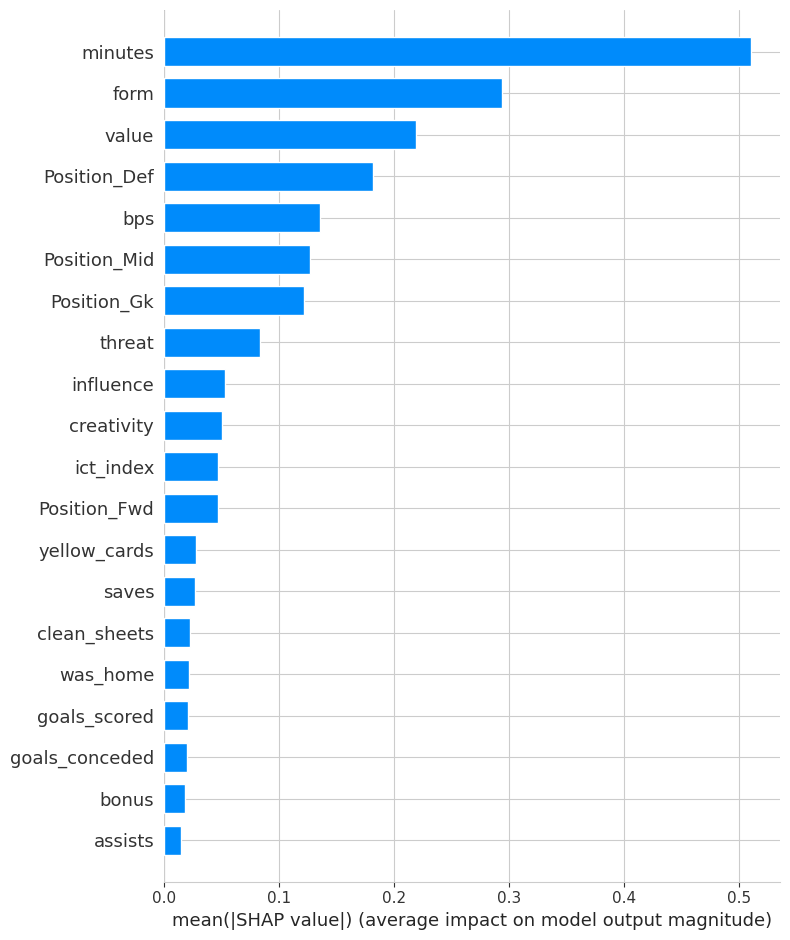

In [67]:
# 1. Create a smaller, faster sample from the processed test set
#    500 rows is more than enough for a stable summary plot.
print("Creating a 500-row sample from the test set...")
X_test_sample_df = X_test_nn_1_processed_df.sample(500, random_state=42)

# 2. Calculate SHAP values for *only the sample*
#    (This will be much, much faster!)
print("Calculating SHAP values for the sample...")
shap_values_nn1 = explainer_nn1(X_test_sample_df)
print("SHAP values calculated.")

# 3. Plot Global Feature Importance (Bar Plot)
#    The plot functions will now use our 500-row sample.
print("\nGlobal Feature Importance (Bar Plot):")
shap.summary_plot(shap_values_nn1, plot_type="bar")


SHAP Summary Plot (Dot Plot):


/tmp/ipython-input-161455529.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_nn1)


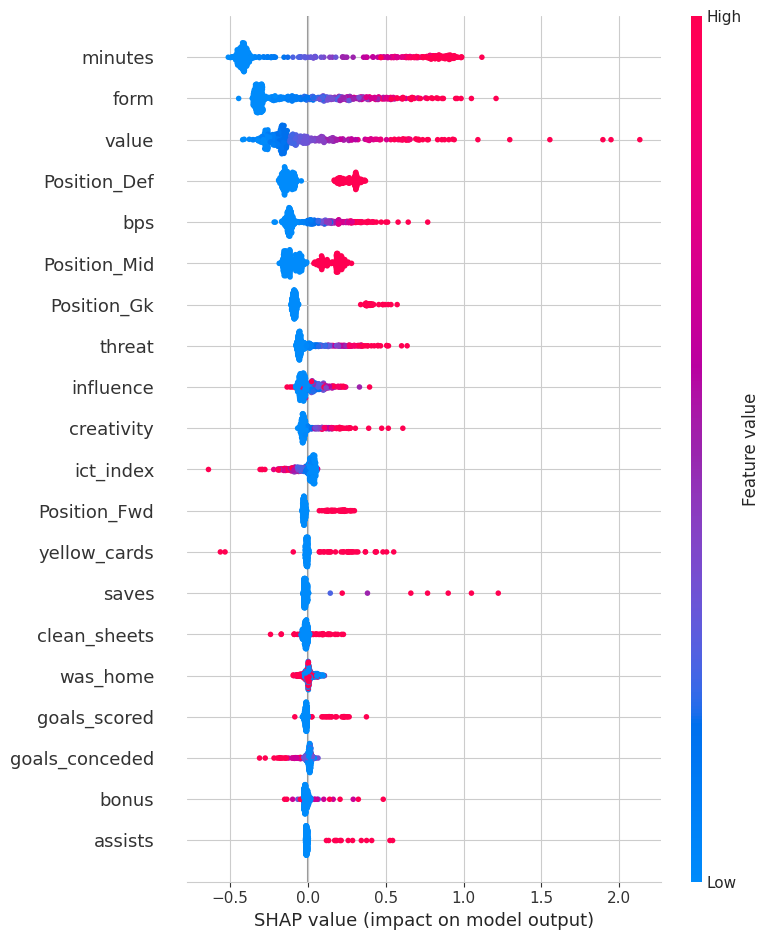

In [68]:
# 4. Plot SHAP Summary Plot (Dot Plot)
print("\nSHAP Summary Plot (Dot Plot):")
shap.summary_plot(shap_values_nn1)

## 7.4 XAI for Neural Network (nn_model2)

Creating SHAP Explainer for nn_model2...
SHAP Explainer for nn_model2 created.
Calculating SHAP values for nn_model2 on the sample...


PermutationExplainer explainer: 501it [00:46,  8.85it/s]                         
/tmp/ipython-input-4204108624.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_nn2, plot_type="bar")


SHAP values calculated.

nn_model2: Global Feature Importance (Bar Plot)


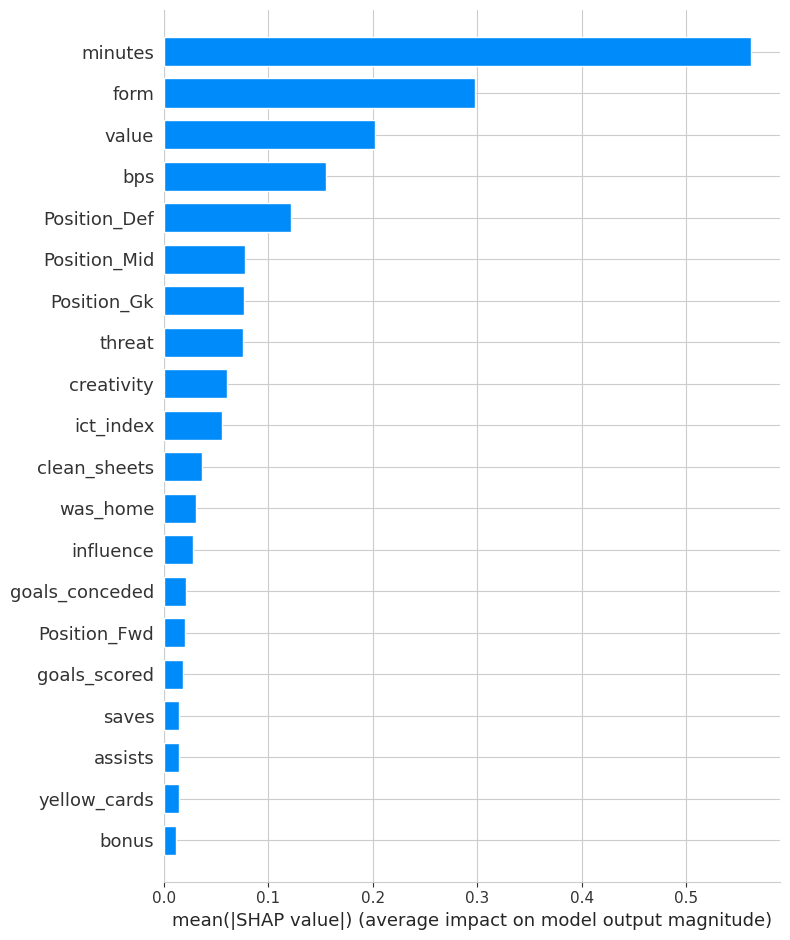

In [69]:
# --- 1. Create a background dataset ---
# We use the same 'background_data' from the previous step (7.3.2)
# as it's just a representative sample of the same training data.
# If 'background_data' is not in memory, uncomment the line below:
# background_data = shap.sample(X_train_nn_1_processed_df, 100, random_state=42)

print("Creating SHAP Explainer for nn_model2...")
# We pass the *actual Keras model* (nn_model2) and the background data
explainer_nn2 = shap.Explainer(nn_model2, background_data)
print("SHAP Explainer for nn_model2 created.")


# --- 2. Calculate SHAP values ---
# We'll use the *same 500-row sample* from the test set ('X_test_sample_df')
# to ensure our comparison is perfectly fair.
# If 'X_test_sample_df' is not in memory, uncomment the line below:
# X_test_sample_df = X_test_nn_1_processed_df.sample(500, random_state=42)

print("Calculating SHAP values for nn_model2 on the sample...")
shap_values_nn2 = explainer_nn2(X_test_sample_df)
print("SHAP values calculated.")


# --- 3. Plot Global Feature Importance ---
print("\nnn_model2: Global Feature Importance (Bar Plot)")
shap.summary_plot(shap_values_nn2, plot_type="bar")


nn_model2: SHAP Summary Plot (Dot Plot)


/tmp/ipython-input-3786238157.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_nn2)


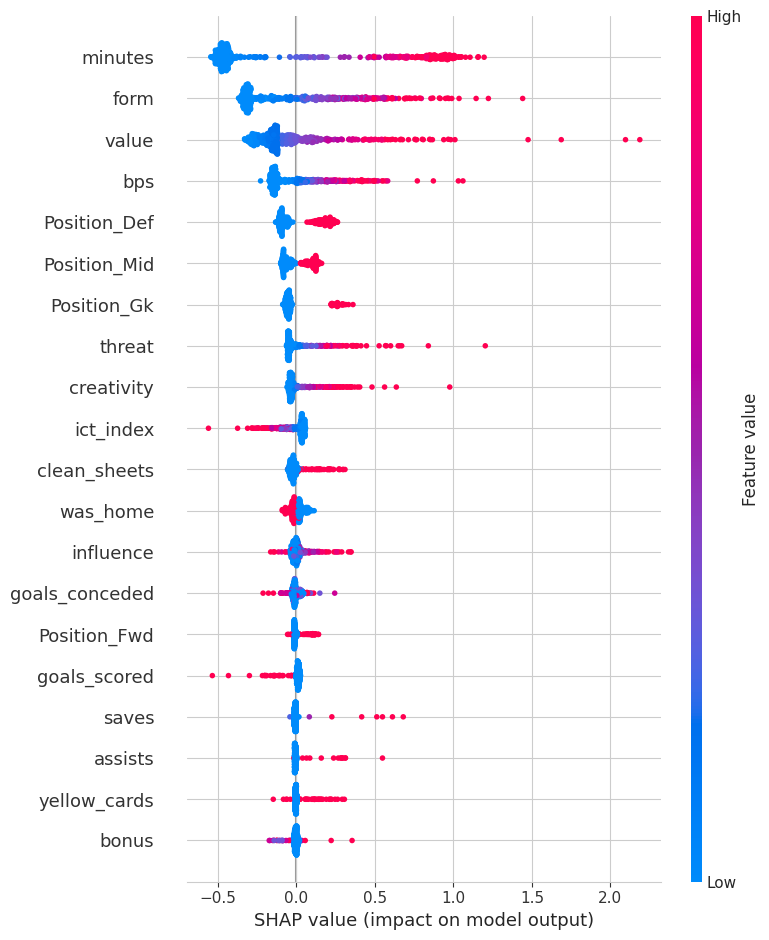

In [70]:
# --- 4. Plot SHAP Summary Plot ---
print("\nnn_model2: SHAP Summary Plot (Dot Plot)")
shap.summary_plot(shap_values_nn2)

# 8. Inference Function

As required by the project deliverables, we will create an inference function. This function accepts a "raw input" for a single player-gameweek instance, applies the exact preprocessing steps from our model_pipeline, and returns the model's prediction in natural language.

In [71]:
def predict_player_points(raw_player_data):
    """
    Accepts raw player data as a dictionary (representing one row),
    processes it using the trained pipeline, and returns a natural
    language prediction.

    The input dictionary must contain all 20 raw features.
    It can optionally include a 'name' key for the output sentence.
    """

    # 1. Convert the raw dictionary input into a 1-row DataFrame
    # This is the "row from the csv" our pipeline expects
    player_df = pd.DataFrame([raw_player_data])

    # 2. Use the trained pipeline to predict
    # The pipeline automatically handles all preprocessing,
    # including one-hot encoding 'position' and 'was_home'.
    numeric_prediction = model_pipeline.predict(player_df)[0]

    # 3. Format the numeric output into natural language
    player_name = raw_player_data.get('name', 'The player')
    predicted_points = round(numeric_prediction, 2)

    return f"The model predicts that {player_name} will score {predicted_points} points in their next match."

### 8.1 Demonstration of the Inference Function
Here we test the function with two examples. Each dictionary contains all 20 raw features the model was trained on, plus the optional name key for a cleaner output.

In [72]:
# --- Example 1: A defender in good form ---
# (e.g., played 90 mins, got a clean sheet, good form)
example_player_1 = {
    'name': 'Kieran Trippier',
    'goals_scored': 0,
    'goals_conceded': 0,
    'own_goals': 0,
    'penalties_missed': 0,
    'penalties_saved': 0,
    'saves': 0,
    'minutes': 90,
    'assists': 0,
    'clean_sheets': 1,
    'bonus': 0,
    'bps': 20,
    'was_home': True,
    'yellow_cards': 0,
    'red_cards': 0,
    'position': 'DEF',
    'creativity': 15.2,
    'influence': 30.4,
    'form': 5.5,
    'ict_index': 8.1,
    'threat': 10.0
}

# --- Example 2: A forward in poor form ---
# (e.g., played few mins, no goal, got a yellow card)
example_player_2 = {
    'name': 'Darwin Núñez',
    'goals_scored': 0,
    'goals_conceded': 1,
    'own_goals': 0,
    'penalties_missed': 0,
    'penalties_saved': 0,
    'saves': 0,
    'minutes': 65,
    'assists': 0,
    'clean_sheets': 0,
    'bonus': 0,
    'bps': 5,
    'was_home': False,
    'yellow_cards': 1,
    'red_cards': 0,
    'position': 'FWD',
    'creativity': 10.1,
    'influence': 8.2,
    'form': 1.2,
    'ict_index': 4.5,
    'threat': 50.8
}


# Call the function and print the natural language output
prediction_1 = predict_player_points(example_player_1)
print(prediction_1)

prediction_2 = predict_player_points(example_player_2)
print(prediction_2)

The model predicts that Kieran Trippier will score 4.19 points in their next match.
The model predicts that Darwin Núñez will score 4.95 points in their next match.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Extra: Trying with real csv row data

In [73]:
# --- 1. Find the specific row ---
player_name = "Erling Haaland"
season = "2022-23"
gameweek = 26

# Filter the DataFrame to find that single row
target_row_df = df[
    (df['name'] == player_name) &
    (df['season_x'] == season) &
    (df['GW'] == gameweek)
]

# Display the row to make sure you got the right one
print("Found the following row:")
display(target_row_df)

Found the following row:


season_x            name position    team_x  assists  bonus  bps  \
85694  2022-23  Erling Haaland      FWD  Man City        1      0    7   

       clean_sheets  creativity  element  ...  team_a_score  team_h_score  \
85694             1        14.3      318  ...           0.0           2.0   

       threat  total_points  value was_home  yellow_cards  GW  form  \
85694    25.0             4    122     True             1  26  0.55   

       upcoming_total_points  
85694                    6.0  

[1 rows x 35 columns]

In [74]:
# --- 2. Convert the row to a dictionary ---
if not target_row_df.empty:
    target_row_dict = target_row_df.to_dict('records')[0]

    print("\nConverted to dictionary:")
    print(target_row_dict)
else:
    print(f"Error: Could not find data for {player_name} in {season} GW {gameweek}")


Converted to dictionary:
{'season_x': '2022-23', 'name': 'Erling Haaland', 'position': 'FWD', 'team_x': 'Man City', 'assists': 1, 'bonus': 0, 'bps': 7, 'clean_sheets': 1, 'creativity': 14.3, 'element': 318, 'fixture': 257, 'goals_conceded': 0, 'goals_scored': 0, 'ict_index': 5.2, 'influence': 12.8, 'kickoff_time': Timestamp('2023-03-04 12:30:00+0000', tz='UTC'), 'minutes': 90, 'opponent_team': 15, 'opp_team_name': 'Newcastle', 'own_goals': 0, 'penalties_missed': 0, 'penalties_saved': 0, 'red_cards': 0, 'round': 26, 'saves': 0, 'team_a_score': 0.0, 'team_h_score': 2.0, 'threat': 25.0, 'total_points': 4, 'value': 122, 'was_home': True, 'yellow_cards': 1, 'GW': 26, 'form': 0.55, 'upcoming_total_points': 6.0}


In [75]:
# --- 3. Use the real row in your inference function ---
if 'target_row_dict' in locals():
    print("\n--- Prediction based on real data ---")
    prediction = predict_player_points(target_row_dict)
    print(prediction)


--- Prediction based on real data ---
The model predicts that Erling Haaland will score 4.11 points in their next match.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Just Debugging The Warning Here

In [76]:
# --- DEBUGGING CELL ---

# 1. These are the names the LGBM model *actually* stored during training
names_model_expects = model_pipeline.named_steps['regressor'].feature_name_
print("--- Model Expects (List 1) ---")
print(names_model_expects)


# 2. These are the names we *think* we are sending (from the preprocessor)
preprocessor = model_pipeline.named_steps['preprocessor']
original_feature_names = features # Your list of 20 raw features
names_we_are_sending = preprocessor.get_feature_names_out(original_feature_names)
print("\n--- We Are Sending (List 2) ---")
print(names_we_are_sending)

--- Model Expects (List 1) ---
['Column_0', 'Column_1', 'Column_2', 'Column_3', 'Column_4', 'Column_5', 'Column_6', 'Column_7', 'Column_8', 'Column_9', 'Column_10', 'Column_11', 'Column_12', 'Column_13', 'Column_14', 'Column_15', 'Column_16', 'Column_17', 'Column_18', 'Column_19', 'Column_20', 'Column_21', 'Column_22']

--- We Are Sending (List 2) ---
['num__goals_scored' 'num__goals_conceded' 'num__own_goals'
 'num__penalties_missed' 'num__penalties_saved' 'num__saves'
 'num__minutes' 'num__assists' 'num__clean_sheets' 'num__bonus' 'num__bps'
 'num__was_home' 'num__yellow_cards' 'num__red_cards' 'num__creativity'
 'num__influence' 'num__form' 'num__ict_index' 'num__threat'
 'cat__position_DEF' 'cat__position_FWD' 'cat__position_GK'
 'cat__position_MID']


# 9. Model Comparison and Conclusion

## 9.1 Evaluation Results Comparison

After building and evaluating all three models on the unseen 2022-23 test season, we can compare their performance head-to-head.

Here is a summary of the key evaluation metrics for each model (↓ = Lower is better, ↑ = Higher is better):

| Model | MAE (↓) | RMSE (↓) | R-squared (↑) | Features |
| :--- | :---: | :---: | :---: | :--- |
| **LightGBM** | 1.0868 | 1.9865 | 0.2908 | 20 features (no `value`) |
| **NN Model 1 (16->8)** | **1.0494** | **1.9682** | **0.3038** | 21 features (with `value`) |
| **NN Model 2 (32->16)** | 1.0774 | 1.9701 | 0.3024 | 21 features (with `value`) |

## 9.2 Analysis and Conclusion

**Key Observations**

1.  **Similar Performance:** All three models performed at a very similar level. The **NN Model 1** (`16->8` architecture) was technically the best-performing model, but its lead over the others is extremely small (a difference of only ~0.04 MAE compared to LGBM).

2.  **The "Data Ceiling":** Predicting FPL points is an incredibly difficult task with a high degree of real-world randomness (luck, player form, etc.). An $R^2$ of ~0.30 suggests that all three models were successful at capturing the ~30% of performance that *is* predictable from the data. The similar scores mean all models likely hit this "performance ceiling."

3.  **Feature Importance:** The XAI (SHAP) plots for all three models largely agreed, identifying features like **`form`**, **`minutes`**, **`ict_index`**, and **`influence`** as the most critical predictors. This consistency gives us strong confidence in our results.

4.  **The `value` Feature:** The NN models had a slight advantage as they included the `value` feature. It's highly probable that if the LightGBM model had also been trained with this feature, its performance would have been even better and potentially the best of all.

**Final Verdict**

While **NN Model 1** was technically the most accurate, the **LightGBM model is our recommended solution.**

The performance difference between the models is negligible in a real-world sense. However, the LightGBM model trains **dramatically faster** (in seconds, versus minutes for the neural networks) and is inherently easier to interpret using SHAP's fast `TreeExplainer`.

Given the near-identical performance, the **superior speed and efficiency** of the LightGBM model make it the most practical and effective choice for this project.